## PH·∫¶N 1: C√ÄI ƒê·∫∂T, IMPORTS & THI·∫æT L·∫¨P BAN ƒê·∫¶U

In [20]:
# ==============================================================================
# CELL 1.1: C√ÄI ƒê·∫∂T TH∆Ø VI·ªÜN & BI·∫æN M√îI TR∆Ø·ªúNG (C·∫¨P NH·∫¨T)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# T·∫£i c√°c bi·∫øn m√¥i tr∆∞·ªùng
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- N√ÇNG C·∫§P: Th√™m c√¥ng c·ª• t√¨m ki·∫øm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Th∆∞ vi·ªán h·ªó tr·ª£ & Kho tri th·ª©c
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: C·∫§U H√åNH LOG & C√ÅC H√ÄM IN ·∫§N
# ==============================================================================
from langchain_groq import ChatGroq
# --- C·∫§U H√åNH LOG ---
VERBOSE_MODE = True

# --- KH·ªûI T·∫†O C√ÅC C√îNG C·ª§ IN ·∫§N ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "K·∫øt qu·∫£"):
    if VERBOSE_MODE:
        console.print(f"[bold green]‚úîÔ∏è {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]‚ö†Ô∏è  {message}[/bold yellow]")

In [22]:
# ==============================================================================
# CELL 1.3: KH·ªûI T·∫†O LLM (N√ÇNG C·∫§P SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # S·ª≠ d·ª•ng model m·ªõi nh·∫•t v√† m·∫°nh nh·∫•t
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("‚úÖ LLM (Gemini 2.5 Flash t·ª´ Google AI Studio) ƒë√£ ƒë∆∞·ª£c kh·ªüi t·∫°o th√†nh c√¥ng.")
except Exception as e:
    print(f"‚ùå L·ªñI: Kh√¥ng th·ªÉ kh·ªüi t·∫°o LLM. H√£y ch·∫Øc ch·∫Øn b·∫°n ƒë√£ c√†i 'langchain-google-genai' v√† c√≥ GOOGLE_API_KEY trong file .env. L·ªói: {e}")
    llm = None

‚úÖ LLM (Gemini 2.5 Flash t·ª´ Google AI Studio) ƒë√£ ƒë∆∞·ª£c kh·ªüi t·∫°o th√†nh c√¥ng.


In [23]:
# ==============================================================================
# CELL 1.4: T·∫¢I KHO TRI TH·ª®C (RAG)
# ==============================================================================
# --- T·∫¢I KHO TRI TH·ª®C ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"‚ùå L·ªñI: Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c con n√†o trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"ƒêang t·∫£i v√† h·ª£p nh·∫•t c√°c kho tri th·ª©c t·ª´ {len(subdirectories)} th∆∞ m·ª•c...")
            # T·∫£i kho tri th·ª©c ƒë·∫ßu ti√™n ƒë·ªÉ l√†m c∆° s·ªü
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"‚úÖ ƒê√£ t·∫£i th√†nh c√¥ng kho tri th·ª©c c∆° s·ªü: '{os.path.basename(first_store_path)}'")

            # H·ª£p nh·∫•t c√°c kho tri th·ª©c c√≤n l·∫°i
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"‚úÖ ƒê√£ h·ª£p nh·∫•t th√†nh c√¥ng: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"B·ªè qua th∆∞ m·ª•c '{os.path.basename(store_path)}' v√¨ kh√¥ng ch·ª©a file index.faiss.")
            
            print("\n[bold green]‚úîÔ∏è T·∫•t c·∫£ c√°c kho tri th·ª©c RAG ƒë√£ ƒë∆∞·ª£c t·∫£i v√† h·ª£p nh·∫•t th√†nh c√¥ng.[/bold green]")

        except Exception as e:
            print(f"‚ùå L·ªñI trong qu√° tr√¨nh t·∫£i ho·∫∑c h·ª£p nh·∫•t kho tri th·ª©c: {e}")
else:
    print(f"‚ùå L·ªñI: Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c g·ªëc c·ªßa kho tri th·ª©c t·∫°i '{BASE_VECTOR_STORE_PATH}'.")


> ƒêang t·∫£i v√† h·ª£p nh·∫•t c√°c kho tri th·ª©c t·ª´ 3 th∆∞ m·ª•c...

‚úÖ ƒê√£ t·∫£i th√†nh c√¥ng kho tri th·ª©c c∆° s·ªü: 'sgk_toan_12_1'
‚úÖ ƒê√£ h·ª£p nh·∫•t th√†nh c√¥ng: 'sgk_toan_12_2'
‚úÖ ƒê√£ h·ª£p nh·∫•t th√†nh c√¥ng: 'sgk_toan_9_1'

[bold green]‚úîÔ∏è T·∫•t c·∫£ c√°c kho tri th·ª©c RAG ƒë√£ ƒë∆∞·ª£c t·∫£i v√† h·ª£p nh·∫•t th√†nh c√¥ng.[/bold green]


In [24]:
# ==============================================================================
# CELL 1.5: KH·ªûI T·∫†O V√Ä QU·∫¢N L√ù TR√ç NH·ªö D√ÄI H·∫†N (N√ÇNG C·∫§P V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# H√†m ƒë·ªÉ t·∫£i tr√≠ nh·ªõ t·ª´ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# H√†m ƒë·ªÉ l∆∞u m·ªôt gi√°o √°n m·ªõi v√†o tr√≠ nh·ªõ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("üß† ƒê√£ l∆∞u gi√°o √°n th√†nh c√¥ng v√†o Tr√≠ nh·ªõ D√†i h·∫°n.")

# H√†m ƒë·ªÉ t·∫°o m·ªôt vector store t·ª´ tr√≠ nh·ªõ (ƒë·ªÉ t√¨m ki·∫øm t∆∞∆°ng ƒë·ªìng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Tr√≠ nh·ªõ tr·ªëng, kh√¥ng c√≥ g√¨ ƒë·ªÉ x√¢y d·ª±ng vector store.")
        return

    # Ch·ªâ l·∫•y ph·∫ßn 'request' ƒë·ªÉ t√¨m ki·∫øm
    texts = [item['request'] for item in memory_content]
    # L∆∞u to√†n b·ªô item l√†m metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("‚úÖ ƒê√£ x√¢y d·ª±ng Vector Store cho Tr√≠ nh·ªõ D√†i h·∫°n.")

# T·ª± ƒë·ªông x√¢y d·ª±ng vector store khi kh·ªüi ƒë·ªông notebook
build_memory_vector_store()

> ‚úÖ ƒê√£ x√¢y d·ª±ng Vector Store cho Tr√≠ nh·ªõ D√†i h·∫°n.

## PH·∫¶N 2: ƒê·ªäNH NGHƒ®A STATE C·ª¶A H·ªÜ TH·ªêNG

In [25]:
# ==============================================================================
# CELL 2.1: ƒê·ªäNH NGHƒ®A STATE N√ÇNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- H√†m ti·ªán √≠ch (gi·ªØ nguy√™n) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- C·∫•u tr√∫c d·ªØ li·ªáu con (gi·ªØ nguy√™n) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    guidance: str
    status: Literal["pending", "completed"]

# === N√ÇNG C·∫§P V9.0: C√ÅC C·∫§U TR√öC D·ªÆ LI·ªÜU M·ªöI CHO T∆Ø DUY S√ÇU ===
class DifferentiatedInstruction(TypedDict):
    """G·ª£i √Ω cho vi·ªác d·∫°y h·ªçc ph√¢n h√≥a trong m·ªôt ho·∫°t ƒë·ªông."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """ƒê·ªãnh nghƒ©a m·ªôt ho·∫°t ƒë·ªông ho·∫∑c ƒë√°nh gi√° c√≥ c·∫•u tr√∫c."""
    task_id: int
    activity_name: str
    question_or_description: str # G·ªôp 'question' v√† 'description'
    duration_minutes: int
    content_type: str # G·ªôp 'activity_type' v√† 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # D√†nh cho c√¢u h·ªèi ƒë√°nh gi√°
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """ƒê·ªãnh nghƒ©a c·∫•u tr√∫c JSON cho gi√°o √°n cu·ªëi c√πng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # D√†nh cho n√¢ng c·∫•p t∆∞∆°ng lai


class TeacherStateV5(TypedDict):
    # C√°c tr∆∞·ªùng c∆° b·∫£n
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # student_persona gi·ªù s·∫Ω ch·ª©a c·∫£ chi·∫øn l∆∞·ª£c ph√¢n h√≥a ===
    student_persona: Optional[Dict[str, Any]] 
    
    # C√°c b∆∞·ªõc tu·∫ßn t·ª± ban ƒë·∫ßu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # C√°c tr∆∞·ªùng n√¢ng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int 
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # C√°c tr∆∞·ªùng t·∫°m th·ªùi cho v√≤ng l·∫∑p ki·ªÉm duy·ªát vi m√¥ (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # Output cu·ªëi c√πng s·∫Ω c√≥ 2 d·∫°ng 
    final_structured_plan: Optional[FinalStructuredPlan] # D·∫°ng JSON c√≥ c·∫•u tr√∫c
    final_markdown_plan: Optional[str] # D·∫°ng Markdown ƒë·ªÉ hi·ªÉn th·ªã


print("‚úÖ 'TeacherStateV5' (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a & C·∫•u tr√∫c) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ 'TeacherStateV5' (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a & C·∫•u tr√∫c) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KH·ªûI T·∫†O STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node ƒë·∫ßu ti√™n trong graph.
    L·∫•y y√™u c·∫ßu g·ªëc t·ª´ tin nh·∫Øn ƒë·∫ßu v√†o v√† ƒëi·ªÅn v√†o tr∆∞·ªùng 'original_request'.
    """
    print_step("`Initializer`: ƒêang kh·ªüi t·∫°o tr·∫°ng th√°i v√† l·∫•y y√™u c·∫ßu g·ªëc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("‚úÖ Node kh·ªüi t·∫°o 'initialize_state_node' ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ Node kh·ªüi t·∫°o 'initialize_state_node' ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


## PH·∫¶N 3: ƒê·ªäNH NGHƒ®A C√ÅC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: H√ÄM TI·ªÜN √çCH & C·∫§U TR√öC D·ªÆ LI·ªÜU (v9.7 - T∆Ø DUY LINH HO·∫†T)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- C√°c h√†m ti·ªán √≠ch gi·ªØ nguy√™n ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Ch∆∞a c√≥ h∆∞·ªõng d·∫´n."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Gi√°o vi√™n quan s√°t v√† h·ªó tr·ª£ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "B·∫†N L√Ä M·ªòT TR·ª¢ L√ù AI CHUY√äN NGHI·ªÜP, ƒê√ìNG VAI TR√í M·ªòT GI√ÅO VI√äN GI√ÄU KINH NGHI·ªÜM T·∫†I VI·ªÜT NAM. LU√îN LU√îN tr·∫£ l·ªùi b·∫±ng TI·∫æNG VI·ªÜT."

# === C·∫¨P NH·∫¨T C·∫§U TR√öC HO·∫†T ƒê·ªòNG LINH HO·∫†T ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="G·ª£i √Ω c·ª• th·ªÉ cho nh√≥m h·ªçc sinh y·∫øu/g·∫∑p kh√≥ khƒÉn.")
    for_advanced_students: str = Field(description="G·ª£i √Ω, th·ª≠ th√°ch ho·∫∑c ho·∫°t ƒë·ªông n√¢ng cao cho nh√≥m h·ªçc sinh gi·ªèi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="T√™n c·ªßa ho·∫°t ƒë·ªông h·ªçc t·∫≠p.")
    activity_type: str = Field(description="Ph√¢n lo·∫°i ho·∫°t ƒë·ªông. V√≠ d·ª•: 'Th·∫£o lu·∫≠n nh√≥m', 'Th·ª±c h√†nh c√° nh√¢n'")
    duration_minutes: int = Field(description="T·ªïng th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng S·ªê PH√öT) cho c·∫£ hai ph·∫ßn.")
    teacher_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông C·ª§ TH·ªÇ c·ªßa GI√ÅO VI√äN.")
    # Thay 'description' b·∫±ng c·∫•u tr√∫c L√µi/M·ªü r·ªông
    core_component: str = Field(description="M√¥ t·∫£ ph·∫ßn ho·∫°t ƒë·ªông C·ªêT L√ïI m√† T·∫§T C·∫¢ h·ªçc sinh c·∫ßn ho√†n th√†nh.")
    extension_component: Optional[str] = Field(description="M√¥ t·∫£ ph·∫ßn ho·∫°t ƒë·ªông M·ªû R·ªòNG d√†nh cho h·ªçc sinh l√†m nhanh ho·∫∑c n·∫øu c√≤n d∆∞ th·ªùi gian.")
    solution_guide: Optional[Any] = Field(description="H∆∞·ªõng d·∫´n gi·∫£i ho·∫∑c c√°c c√¢u h·ªèi g·ª£i m·ªü.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="G·ª£i √Ω ph√¢n h√≥a c·ª• th·ªÉ cho ho·∫°t ƒë·ªông n√†y.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="T√™n c·ªßa ho·∫°t ƒë·ªông ƒë√°nh gi√°.")
    question_type: str = Field(description="Lo·∫°i c√¢u h·ªèi. V√≠ d·ª•: 'T·ª± lu·∫≠n', 'Tr·∫Øc nghi·ªám'")
    duration_minutes: int = Field(description="T·ªïng th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng S·ªê PH√öT) cho c·∫£ hai ph·∫ßn.")
    teacher_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông C·ª§ TH·ªÇ c·ªßa GI√ÅO VI√äN.")
    # Thay 'question' b·∫±ng c·∫•u tr√∫c L√µi/M·ªü r·ªông
    core_component: str = Field(description="N·ªôi dung c√¢u h·ªèi ho·∫∑c ƒë·ªÅ b√†i C·ªêT L√ïI m√† T·∫§T C·∫¢ h·ªçc sinh c·∫ßn ho√†n th√†nh.")
    extension_component: Optional[str] = Field(description="C√¢u h·ªèi ph·ª• ho·∫∑c th·ª≠ th√°ch M·ªû R·ªòNG d√†nh cho h·ªçc sinh l√†m nhanh ho·∫∑c n·∫øu c√≤n d∆∞ th·ªùi gian.")
    answer: str = Field(description="ƒê√°p √°n ch√≠nh x√°c v√† ng·∫Øn g·ªçn cho ph·∫ßn C·ªêT L√ïI.")
    solution_guide: Any = Field(description="H∆∞·ªõng d·∫´n gi·∫£i chi ti·∫øt t·ª´ng b∆∞·ªõc.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="G·ª£i √Ω ph√¢n h√≥a c·ª• th·ªÉ cho ho·∫°t ƒë·ªông n√†y.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung b√¨nh", "ch·∫≠m"] = Field(description="T·ªëc ƒë·ªô h·ªçc t·∫≠p chung c·ªßa l·ªõp.")
    engagement_style: Literal["ch·ªß ƒë·ªông", "th·ª• ƒë·ªông", "h·ªón h·ª£p"] = Field(description="M·ª©c ƒë·ªô tham gia chung c·ªßa l·ªõp.")
    special_notes: str = Field(description="T√≥m t·∫Øt c√°c ƒë·∫∑c ƒëi·ªÉm n·ªïi b·∫≠t c·ªßa l·ªõp h·ªçc.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chi·∫øn l∆∞·ª£c d·∫°y h·ªçc ph√¢n h√≥a t·ªïng th·ªÉ cho c·∫£ b√†i h·ªçc d·ª±a tr√™n c√°c ƒë·∫∑c ƒëi·ªÉm c·ªßa l·ªõp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="T√™n c·ªßa nhi·ªám v·ª• n√†y.")
    task_description: str = Field(description="M√¥ t·∫£ chi ti·∫øt nhi·ªám v·ª• c·∫ßn th·ª±c hi·ªán.")
    estimated_duration: int = Field(description="Th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng ph√∫t) cho nhi·ªám v·ª• n√†y.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="T√™n c·ªßa ph∆∞∆°ng ph√°p s∆∞ ph·∫°m ƒë∆∞·ª£c ch·ªçn.")
    rationale: str = Field(description="L√Ω do t·∫°i sao ph∆∞∆°ng ph√°p n√†y ph√π h·ª£p.")
    key_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông/ho·∫°t ƒë·ªông c·ªët l√µi ƒë·∫∑c tr∆∞ng cho ph∆∞∆°ng ph√°p n√†y.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="N·ªôi dung c√≥ h·ª£p l·ªá v√† ch√≠nh x√°c v·ªÅ m·∫∑t chuy√™n m√¥n kh√¥ng.")
    feedback: str = Field(description="Ph·∫£n h·ªìi chi ti·∫øt. N·∫øu kh√¥ng h·ª£p l·ªá, h√£y gi·∫£i th√≠ch r√µ r√†ng l·ªói sai v√† g·ª£i √Ω c√°ch s·ª≠a.")

class Domain(BaseModel): domain: str = Field(description="Lƒ©nh v·ª±c h·ªçc thu·∫≠t ch√≠nh c·ªßa y√™u c·∫ßu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("‚úÖ C√°c c·∫•u tr√∫c d·ªØ li·ªáu Pydantic (v9.7 - Ho·∫°t ƒë·ªông Linh ho·∫°t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ C√°c c·∫•u tr√∫c d·ªØ li·ªáu Pydantic (v9.7 - Ho·∫°t ƒë·ªông Linh ho·∫°t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PH√ÇN T√çCH Y√äU C·∫¶U BAN ƒê·∫¶U 
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) ƒëang ph√¢n t√≠ch m·ª•c ti√™u...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu c·ªßa ng∆∞·ªùi d√πng v√† tr√≠ch xu·∫•t c√°c th√¥ng tin sau.\n**Y√äU C·∫¶U:** \"{state['original_request']}\"\n**C√ÅC TR∆Ø·ªúNG C·∫¶N TR√çCH XU·∫§T:** `action_verb`, `bloom_level` (S·ªê NGUY√äN), `topic`, `grade_level`, `duration_minutes`.\n**CH·ªà TR·∫¢ V·ªÄ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "M·ª•c ti√™u & R√†ng bu·ªôc ƒë√£ ph√¢n t√≠ch")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Objective Interpreter: {e}. S·ª≠ d·ª•ng m·ª•c ti√™u m·∫∑c ƒë·ªãnh.")
        return {"analyzed_objective": { "action_verb": "so·∫°n", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) ƒëang x√°c ƒë·ªãnh lƒ©nh v·ª±c chuy√™n m√¥n...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu c·ªßa ng∆∞·ªùi d√πng v√† x√°c ƒë·ªãnh lƒ©nh v·ª±c h·ªçc thu·∫≠t ch√≠nh.\n**Y√äU C·∫¶U:** \"{state['original_request']}\"\n**Lƒ®NH V·ª∞C C√ì TH·ªÇ CH·ªåN:** 'To√°n h·ªçc', 'V·∫≠t l√Ω', 'H√≥a h·ªçc', 'Sinh h·ªçc', 'VƒÉn h·ªçc', 'L·ªãch s·ª≠', 'ƒê·ªãa l√Ω', 'Ngo·∫°i ng·ªØ', 'Tin h·ªçc'.\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lƒ©nh v·ª±c chuy√™n m√¥n ƒë∆∞·ª£c x√°c ƒë·ªãnh")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Domain Classifier: {e}. S·ª≠ d·ª•ng lƒ©nh v·ª±c m·∫∑c ƒë·ªãnh 'To√°n h·ªçc'.")
        return {"domain": "To√°n h·ªçc"}

# === N√ÇNG C·∫§P: Agent n√†y gi·ªù ƒë√¢y l√† m·ªôt nh√† t∆∞ v·∫•n chi·∫øn l∆∞·ª£c ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) ƒëang ph√¢n t√≠ch v√† ƒë·ªÅ xu·∫•t chi·∫øn l∆∞·ª£c ph√¢n h√≥a...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt chuy√™n gia s∆∞ ph·∫°m, chuy√™n v·ªÅ d·∫°y h·ªçc ph√¢n h√≥a.
    **NHI·ªÜM V·ª§:** Ph√¢n t√≠ch m√¥ t·∫£ v·ªÅ l·ªõp h·ªçc d∆∞·ªõi ƒë√¢y v√† ƒë·ªÅ xu·∫•t m·ªôt chi·∫øn l∆∞·ª£c d·∫°y h·ªçc ph√¢n h√≥a T·ªîNG TH·ªÇ cho c·∫£ bu·ªïi h·ªçc.
    **Y√äU C·∫¶U C·ª¶A GI√ÅO VI√äN:** "{state['original_request']}"
    
    **C√ÅC B∆Ø·ªöC SUY LU·∫¨N (B·∫ÆT BU·ªòC):**
    1.  **Ph√¢n t√≠ch ƒê·∫∑c ƒëi·ªÉm:** D·ª±a v√†o c√°c t·ª´ kh√≥a, h√£y x√°c ƒë·ªãnh `learning_pace`, `engagement_style`, v√† t√≥m t·∫Øt v√†o `special_notes`.
    2.  **ƒê·ªÅ xu·∫•t Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a:** D·ª±a tr√™n ph√¢n t√≠ch tr√™n, h√£y ƒëi·ªÅn v√†o ƒë·ªëi t∆∞·ª£ng `differentiation_strategy`. ƒê√¢y PH·∫¢I l√† m·ªôt ƒë·ªëi t∆∞·ª£ng JSON c√≥ 2 tr∆∞·ªùng sau:
        -   `for_struggling_students`: M·ªôt chi·∫øn l∆∞·ª£c c·ª• th·ªÉ ƒë·ªÉ **h·ªó tr·ª£** nh√≥m h·ªçc sinh c√≥ th·ªÉ g·∫∑p kh√≥ khƒÉn. (V√≠ d·ª•: "Chia nh·ªè nhi·ªám v·ª•, cung c·∫•p phi·∫øu b√†i t·∫≠p c√≥ g·ª£i √Ω c√¥ng th·ª©c, cho ph√©p th√™m th·ªùi gian.")
        -   `for_advanced_students`: M·ªôt chi·∫øn l∆∞·ª£c c·ª• th·ªÉ ƒë·ªÉ **th·ª≠ th√°ch** nh√≥m h·ªçc sinh kh√° gi·ªèi. (V√≠ d·ª•: "Chu·∫©n b·ªã c√°c c√¢u h·ªèi m·ªü r·ªông 'T·∫°i sao?' v√† 'N·∫øu... th√¨ sao?', giao m·ªôt b√†i to√°n ·ª©ng d·ª•ng th·ª±c t·∫ø nh·ªè.")

    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** B·∫ÆT BU·ªòC tr·∫£ v·ªÅ m·ªôt ƒë·ªëi t∆∞·ª£ng JSON duy nh·∫•t tu√¢n th·ªß schema `StudentPersonaAndDifferentiation`. Tr∆∞·ªùng `differentiation_strategy` PH·∫¢I l√† m·ªôt object l·ªìng v√†o b√™n trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "H·ªì s∆° l·ªõp h·ªçc v√† Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Differentiated Instruction Advisor: {e}. S·ª≠ d·ª•ng h·ªì s∆° m·∫∑c ƒë·ªãnh.")
        fallback_persona = {
            "learning_pace": "trung b√¨nh",
            "engagement_style": "h·ªón h·ª£p",
            "special_notes": "Kh√¥ng c√≥ ghi ch√∫ ƒë·∫∑c bi·ªát.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan s√°t v√† h·ªó tr·ª£ th√™m khi c·∫ßn thi·∫øt.",
                "for_advanced_students": "Khuy·∫øn kh√≠ch c√°c em t√¨m t√≤i th√™m."
            }
        }
        return {"student_persona": fallback_persona}

print("‚úÖ C√°c agent ph√¢n t√≠ch y√™u c·∫ßu ban ƒë·∫ßu (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a) ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent ph√¢n t√≠ch y√™u c·∫ßu ban ƒë·∫ßu (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a) ƒë√£ s·∫µn s√†ng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT L·∫¨P K·∫æ HO·∫†CH CHI·∫æN L∆Ø·ª¢C (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) ƒëang x√¢y d·ª±ng chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **M·ª§C TI√äU B√ÄI H·ªåC:** {state.get('analyzed_objective')}
    **H·ªí S∆† L·ªöP H·ªåC:** {state.get('student_persona')}
    **NHI·ªÜM V·ª§:** D·ª±a v√†o m·ª•c ti√™u v√† h·ªì s∆° l·ªõp h·ªçc, h√£y ch·ªçn M·ªòT ph∆∞∆°ng ph√°p s∆∞ ph·∫°m ph√π h·ª£p nh·∫•t. Sau ƒë√≥, ph√¢n t√≠ch ph∆∞∆°ng ph√°p ƒë√≥ th√†nh c√°c h√†nh ƒë·ªông c·ªët l√µi.
    **V√ç D·ª§:** N·∫øu ch·ªçn 'D·∫°y h·ªçc theo d·ª± √°n', key_actions c√≥ th·ªÉ l√† ["Giao d·ª± √°n", "H·ªçc sinh l√†m vi·ªác nh√≥m", "B√°o c√°o s·∫£n ph·∫©m"].
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi c√°c key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Pedagogy Strategist: {e}. S·ª≠ d·ª•ng chi·∫øn l∆∞·ª£c m·∫∑c ƒë·ªãnh.")
        return {"pedagogy_strategy": {"name": "D·∫°y h·ªçc gi·∫£i quy·∫øt v·∫•n ƒë·ªÅ", "rationale": "M·∫∑c ƒë·ªãnh do l·ªói.", "key_actions": ["N√™u v·∫•n ƒë·ªÅ", "H·ªçc sinh t√¨m gi·∫£i ph√°p", "Tr√¨nh b√†y k·∫øt qu·∫£"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) ƒëang thi·∫øt k·∫ø k·ªãch b·∫£n bu·ªïi h·ªçc...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **V√ç D·ª§ THAM KH·∫¢O (T·ª™ M·ªòT GI√ÅO √ÅN TH√ÄNH C√îNG TR∆Ø·ªöC ƒê√ÇY):**
        ƒê√¢y l√† m·ªôt lu·ªìng ho·∫°t ƒë·ªông ƒë√£ ƒë∆∞·ª£c ch·ª©ng minh l√† hi·ªáu qu·∫£ cho m·ªôt ch·ªß ƒë·ªÅ t∆∞∆°ng t·ª±. H√£y h·ªçc h·ªèi c·∫•u tr√∫c v√† c√°ch ti·∫øp c·∫≠n t·ª´ n√≥:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} V·ªõi vai tr√≤ l√† m·ªôt chuy√™n gia thi·∫øt k·∫ø tr·∫£i nghi·ªám h·ªçc t·∫≠p.
    **NHI·ªÜM V·ª§:** X√¢y d·ª±ng m·ªôt "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m" - m·ªôt k·ªãch b·∫£n C·∫§P CAO cho bu·ªïi h·ªçc.
    
    {example_prompt_part}
    **QUY T·∫ÆC:**
    1.  T·∫°o ra 3-5 giai ƒëo·∫°n ch√≠nh cho d√≤ng ch·∫£y c·ªßa bu·ªïi h·ªçc.
    2.  M·ªói giai ƒëo·∫°n ph·∫£i c√≥ t√™n (`stage_name`), m·ª•c ti√™u (`stage_objective`), v√† ƒë·ªãnh h∆∞·ªõng (`stage_direction`).
    3.  ƒê·∫£m b·∫£o ƒë·ªô kh√≥ tƒÉng ti·∫øn qua c√°c giai ƒëo·∫°n.
    **TH√îNG TIN PH√ÇN T√çCH:**
    - M·ª•c ti√™u: {state.get('analyzed_objective')}
    - H·ªì s∆° l·ªõp h·ªçc: {state.get('student_persona')}
    - Chi·∫øn l∆∞·ª£c S∆∞ ph·∫°m: {state.get('pedagogy_strategy')}
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key l√† `blueprint`, gi√° tr·ªã l√† m·ªôt danh s√°ch c√°c ƒë·ªëi t∆∞·ª£ng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m ƒë√£ ƒë∆∞·ª£c t·∫°o")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Pedagogical Architect: {e}. S·ª≠ d·ª•ng blueprint m·∫∑c ƒë·ªãnh.")
        return {"pedagogical_blueprint": ["Giai ƒëo·∫°n 1: Gi·ªõi thi·ªáu b√†i h·ªçc", "Giai ƒëo·∫°n 2: Luy·ªán t·∫≠p", "Giai ƒëo·∫°n 3: ƒê√°nh gi√°"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) ƒëang t√¨m ki·∫øm trong tr√≠ nh·ªõ...")
    
    if not memory_vector_store:
        print_warning("Kh√¥ng c√≥ Tr√≠ nh·ªõ D√†i h·∫°n. B·ªè qua b∆∞·ªõc n√†y.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # T√¨m ki·∫øm 1 v√≠ d·ª• t∆∞∆°ng ƒë·ªìng nh·∫•t trong tr√≠ nh·ªõ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Ch·ªâ l·∫•y n·∫øu ƒë·ªô t∆∞∆°ng ƒë·ªìng cao (ƒëi·ªÉm score th·∫•p l√† t·ªët)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "T√¨m th·∫•y v√≠ d·ª• t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ")
            # Ch·ªâ tr·∫£ v·ªÅ ph·∫ßn "lesson_flow" ƒë·ªÉ l√†m v√≠ d·ª•
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Kh√¥ng t√¨m th·∫•y v√≠ d·ª• n√†o ƒë·ªß t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"L·ªói khi truy xu·∫•t tr√≠ nh·ªõ: {e}")
        return {"inspirational_example": None}
    
print("‚úÖ C√°c agent l·∫≠p k·∫ø ho·∫°ch chi·∫øn l∆∞·ª£c ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent l·∫≠p k·∫ø ho·∫°ch chi·∫øn l∆∞·ª£c ƒë√£ s·∫µn s√†ng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XU·∫§T V√Ä T·ªîNG H·ª¢P KI·∫æN TH·ª®C (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) ƒëang ph√¢n t√≠ch y√™u c·∫ßu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** T·∫°o ra c√°c c·ª•m t·ª´ t√¨m ki·∫øm ƒëa d·∫°ng b·∫±ng ti·∫øng Vi·ªát ƒë·ªÉ t√¨m t√†i li·ªáu.\n**CH·ª¶ ƒê·ªÄ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**Lƒ®NH V·ª∞C:** {state.get('domain', 'Chung')}\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "C√°c truy v·∫•n t√¨m ki·∫øm ƒë√£ ƒë∆∞·ª£c m·ªü r·ªông")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Query Expansion: {e}. S·ª≠ d·ª•ng truy v·∫•n g·ªëc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - S·ª≠a l·ªói) ƒëang t√¨m ki·∫øm v√† s√†ng l·ªçc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"T√¨m th·∫•y {len(all_docs)} t√†i li·ªáu, s√†ng l·ªçc c√≤n {len(unique_docs_content)} ƒëo·∫°n vƒÉn b·∫£n ƒë·ªôc nh·∫•t.")
    
    # --- Ph·∫ßn Re-ranker gi·ªØ nguy√™n ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu g·ªëc v√† ch·ªçn ra 3-4 ƒëo·∫°n vƒÉn b·∫£n ti·∫øng Vi·ªát ph√π h·ª£p NH·∫§T t·ª´ danh s√°ch d∆∞·ªõi ƒë√¢y.\n**Y√äU C·∫¶U G·ªêC:** \"{state.get('original_request', '')}\"\n**DANH S√ÅCH T√ÄI LI·ªÜU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Re-ranker: {e}. S·ª≠ d·ª•ng t·∫•t c·∫£ t√†i li·ªáu.")

    # === ƒê·∫†I TU PROMPT T√ìM T·∫ÆT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt gi√°o vi√™n kinh nghi·ªám, c√≥ kh·∫£ nƒÉng di·ªÖn gi·∫£i c√°c t√†i li·ªáu kh√¥ khan th√†nh m·ªôt b√†i t√≥m t·∫Øt ki·∫øn th·ª©c c·ªët l√µi v·ª´a CH√çNH X√ÅC, v·ª´a H·∫§P D·∫™N cho h·ªçc sinh.

    **NHI·ªÜM V·ª§:** D·ª±a **CH·ªà** v√†o c√°c ƒëo·∫°n vƒÉn b·∫£n d∆∞·ªõi ƒë√¢y, h√£y vi·∫øt m·ªôt b·∫£n **T√ìM T·∫ÆT KI·∫æN TH·ª®C C·ªêT L√ïI** v·ªÅ ch·ªß ƒë·ªÅ "{state.get('analyzed_objective', {}).get('topic', '')}" ƒë·ªÉ in v√†o cu·ªëi gi√°o √°n.

    **QUY T·∫ÆC V·ªÄ PHONG C√ÅCH:**
    1.  **VƒÇN PHONG T·ª∞ NHI√äN:** H√£y vi·∫øt nh∆∞ th·ªÉ b·∫°n ƒëang gi·∫£i th√≠ch tr·ª±c ti·∫øp cho h·ªçc sinh. B·∫Øt ƒë·∫ßu m·ªôt c√°ch t·ª± nhi√™n, kh√¥ng c·∫ßn c√°c c√¢u r√†o ƒë√≥n nh∆∞ "V·ªõi vai tr√≤ l√† m·ªôt gi√°o vi√™n...".
    2.  **T·∫¨P TRUNG V√ÄO "ƒêI·ªÇM NH·∫§N":** ƒê·ª´ng ch·ªâ li·ªát k√™. H√£y c·ªë g·∫Øng nh√≥m c√°c √Ω, t√¨m ra nh·ªØng ƒëi·ªÉm quan tr·ªçng nh·∫•t v√† nh·∫•n m·∫°nh ch√∫ng. S·ª≠ d·ª•ng g·∫°ch ƒë·∫ßu d√≤ng, **in ƒë·∫≠m** ƒë·ªÉ l√†m n·ªïi b·∫≠t.
    3.  **CH√çNH X√ÅC TUY·ªÜT ƒê·ªêI:** Ch·ªâ ƒë∆∞·ª£c ph√©p s·ª≠ d·ª•ng th√¥ng tin c√≥ trong c√°c ƒëo·∫°n vƒÉn b·∫£n ƒë∆∞·ª£c cung c·∫•p. N·∫øu th√¥ng tin v·ªÅ m·ªôt ph·∫ßn n√†o ƒë√≥ (v√≠ d·ª•: "ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp") kh√¥ng c√≥, h√£y ghi r√µ l√† "Th√¥ng tin v·ªÅ ph·∫ßn n√†y kh√¥ng c√≥ trong t√†i li·ªáu tham kh·∫£o."

    **C√ÅC ƒêO·∫†N VƒÇN B·∫¢N ƒê·ªÇ T√ìM T·∫ÆT:**
    ---
    {best_snippets_text}
    ---
    """

    summary = "Ch∆∞a c√≥ b·∫£n t√≥m t·∫Øt ki·∫øn th·ª©c."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"L·ªói t·∫°i b∆∞·ªõc t√≥m t·∫Øt: {e}.")
        
    resource = {"source": "S√°ch gi√°o khoa (t·ª´ RAG - ƒë√£ s√†ng l·ªçc)", "summary": summary}
    print_result(resource, "T√†i li·ªáu RAG cu·ªëi c√πng")
    return update_agent_outputs(state, "resources", resource)

print("‚úÖ C√°c agent RAG ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent RAG ƒë√£ s·∫µn s√†ng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VI·ªÜC & CHUY√äN M√îN 
# ==============================================================================

class DetailedTaskWithGuidance(BaseModel):
    task_name: str = Field(description="T√™n c·ªßa nhi·ªám v·ª• n√†y, ph·∫£i ph·∫£n √°nh M·ªòT m·ª•c ti√™u duy nh·∫•t.")
    task_description: str = Field(description="M√¥ t·∫£ chi ti·∫øt nhi·ªám v·ª• c·∫ßn th·ª±c hi·ªán.")
    estimated_duration: int = Field(description="Th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng ph√∫t) cho nhi·ªám v·ª• n√†y.")
    guidance: str = Field(description="M·ªôt ch·ªâ d·∫´n s∆∞ ph·∫°m NG·∫ÆN G·ªåN v√† C·ª§ TH·ªÇ cho agent chuy√™n m√¥n.")

class TaskListWithGuidance(BaseModel):
    tasks: List[DetailedTaskWithGuidance]

async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Headmaster Delegator` (v13.1 - Giao vi·ªác Th√¥ng minh) ƒëang ch·ªâ ƒë·∫°o...")
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt Hi·ªáu tr∆∞·ªüng c·ª±c k·ª≥ kinh nghi·ªám, chuy√™n thi·∫øt k·∫ø c√°c lu·ªìng ho·∫°t ƒë·ªông s∆∞ ph·∫°m.
    **NHI·ªÜM V·ª§:** Chuy·ªÉn ƒë·ªïi "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m" c·∫•p cao th√†nh m·ªôt danh s√°ch c√°c nhi·ªám v·ª• C√ì √ù NGHƒ®A v√† KH·∫¢ THI.

    **TH√îNG TIN B·ªêI C·∫¢NH:**
    - B·∫£n thi·∫øt k·∫ø: {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    - T·ªïng th·ªùi gian: **{total_duration} ph√∫t.**

    **QUY T·∫ÆC TUY·ªÜT ƒê·ªêI PH·∫¢I TU√ÇN THEO:**
    1.  **GOM NH√ìM HO·∫†T ƒê·ªòNG:** Tuy·ªát ƒë·ªëi **KH√îNG** ƒë∆∞·ª£c t·∫°o c√°c nhi·ªám v·ª• v·ª•n v·∫∑t d∆∞·ªõi 10 ph√∫t. H√£y t·∫°o ra kho·∫£ng **5-7 nhi·ªám v·ª• ch√≠nh** cho to√†n b·ªô bu·ªïi h·ªçc.
    2.  **PH√ÇN B·ªî TH·ªúI GIAN H·ª¢P L√ù:** `estimated_duration` c·ªßa m·ªói nhi·ªám v·ª• ph·∫£i h·ª£p l√Ω (v√≠ d·ª•: 10, 15, 20 ph√∫t) v√† t·ªïng th·ªùi gian c·ªßa t·∫•t c·∫£ c√°c nhi·ªám v·ª• n√™n x·∫•p x·ªâ {total_duration} ph√∫t.
    3.  **M·ª§C TI√äU R√ï R√ÄNG:** `task_name` v√† `task_description` ph·∫£i m√¥ t·∫£ m·ªôt m·ª•c ti√™u h·ªçc t·∫≠p r√µ r√†ng.
    4.  **CH·ªà D·∫™N NG·∫ÆN G·ªåN:** `guidance` ph·∫£i l√† m·ªôt m·ªánh l·ªánh ng·∫Øn g·ªçn, t·∫≠p trung v√†o k·∫øt qu·∫£ ƒë·∫ßu ra.

    **V√ç D·ª§ T·ªêT (Cho 90 ph√∫t):**
    - Task 1: Kh·ªüi ƒë·ªông & Gi·ªõi thi·ªáu b√†i h·ªçc (15 ph√∫t)
    - Task 2: Ho·∫°t ƒë·ªông nh√≥m kh√°m ph√° l√Ω thuy·∫øt (25 ph√∫t)
    - Task 3: Luy·ªán t·∫≠p c√≥ h∆∞·ªõng d·∫´n (20 ph√∫t)
    - Task 4: Tr√¨nh b√†y v√† th·∫£o lu·∫≠n chung (15 ph√∫t)
    - Task 5: ƒê√°nh gi√° nhanh v√† t·ªïng k·∫øt (15 ph√∫t)

    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON theo schema `TaskListWithGuidance`.
    """
    structured_llm = llm.with_structured_output(TaskListWithGuidance, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"ƒê√£ t·∫°o {len(tasks_with_status)} nhi·ªám v·ª• v·ªõi ch·ªâ d·∫´n chi ti·∫øt")
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Headmaster Delegator: {e}. T·∫°o task m·∫∑c ƒë·ªãnh.")
        fallback_task = { "task_id": 0, "task_name": "Ho·∫°t ƒë·ªông luy·ªán t·∫≠p", "task_description": "H·ªçc sinh th·ª±c h√†nh b√†i t·∫≠p.", "estimated_duration": 45, "guidance": "Ch·ªâ c·∫ßn 2 b√†i t·∫≠p.", "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}
    
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Kh√¥ng t√¨m th·∫•y task hi·ªán t·∫°i."}}

    feedback_prompt = ""
    # CH·ªà k√≠ch ho·∫°t ch·∫ø ƒë·ªô s·ª≠a ch·ªØa khi c√≥ feedback V√Ä ƒë√¢y l√† l·∫ßn th·ª≠ l·∫°i
    if state.get('validation_feedback') and state.get('current_task_retry_count', 0) > 0:
        feedback_prompt = f"""
    **üö® C·∫¢NH B√ÅO: B·∫¢N NH√ÅP TR∆Ø·ªöC B·ªä Y√äU C·∫¶U S·ª¨A ƒê·ªîI! üö®**
    ƒê√¢y l√† l·∫ßn s·ª≠a DUY NH·∫§T, v√¨ v·∫≠y h√£y l√†m cho ƒë√∫ng.
    **M·ªÜNH L·ªÜNH S·ª¨A CH·ªÆA T·ª™ C·ªê V·∫§N:** "{state.get('validation_feedback', '')}"
    
    **QUY TR√åNH T∆Ø DUY B·∫ÆT BU·ªòC TR∆Ø·ªöC KHI H√ÄNH ƒê·ªòNG:**
    1.  **Ph√¢n t√≠ch L·ªói Sai:** B·∫£n nh√°p tr∆∞·ªõc ƒë√£ sai ·ªü ƒë√¢u so v·ªõi m·ªánh l·ªánh? (V√≠ d·ª•: "T√¥i ƒë√£ th√™m ph·∫ßn `differentiation` trong khi c·ªë v·∫•n y√™u c·∫ßu lo·∫°i b·ªè n√≥.")
    2.  **L·∫≠p K·∫ø ho·∫°ch S·ª≠a ch·ªØa:** ƒê·ªÉ tu√¢n th·ªß tuy·ªát ƒë·ªëi m·ªánh l·ªánh, t√¥i s·∫Ω ph·∫£i thay ƒë·ªïi nh·ªØng g√¨? (V√≠ d·ª•: "T√¥i s·∫Ω t·∫°o ra m·ªôt JSON m·ªõi, copy ph·∫ßn c·ªët l√µi v√† ƒë·∫£m b·∫£o r·∫±ng c√°c tr∆∞·ªùng `extension_component` v√† `differentiation` ƒë·ªÅu l√† `null`.")
    3.  **T·∫°o N·ªôi dung M·ªõi:** D·ª±a tr√™n k·∫ø ho·∫°ch s·ª≠a ch·ªØa, t·∫°o ra m·ªôt JSON ho√†n to√†n m·ªõi. **TUY·ªÜT ƒê·ªêI KH√îNG S√ÅNG T·∫†O TH√äM** ngo√†i m·ªánh l·ªánh.
    """
    
    duration = task_to_run.get('estimated_duration', 10)

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt nh√† thi·∫øt k·∫ø ho·∫°t ƒë·ªông h·ªçc t·∫≠p, m·ªôt c·ªó m√°y tu√¢n th·ªß m·ªánh l·ªánh m·ªôt c√°ch tuy·ªát ƒë·ªëi.

    {feedback_prompt}

    **M·ªÜNH L·ªÜNH G·ªêC (Ch·ªâ tu√¢n theo n·∫øu kh√¥ng c√≥ C·∫¢NH B√ÅO ·ªü tr√™n):**
    - Nhi·ªám-v·ª•: "{task_to_run.get('task_name', '')}"
    - Ch·ªâ-d·∫´n: "{task_to_run.get('guidance', 'Kh√¥ng c√≥ ch·ªâ d·∫´n c·ª• th·ªÉ.')}"
    - Th·ªùi-gian-ƒë∆∞·ª£c-giao: **{duration} ph√∫t.**

    **=== QUY T·∫ÆC S·ªêNG C√íN ===**
    1.  **TU√ÇN TH·ª¶ TH·ªúI GIAN TUY·ªÜT ƒê·ªêI:** `duration_minutes` trong JSON b·∫°n tr·∫£ v·ªÅ **PH·∫¢I B·∫∞NG CH√çNH X√ÅC** con s·ªë ƒë∆∞·ª£c giao: **{duration} ph√∫t**. Kh√¥ng ƒë∆∞·ª£c t·ª± √Ω thay ƒë·ªïi d√π ch·ªâ 1 ph√∫t. ƒê√¢y l√† m·ªánh l·ªánh quan tr·ªçng nh·∫•t.
    2.  **T·ª∞ ƒêI·ªÄU CH·ªàNH N·ªòI DUNG:** H√£y t·ª± ƒëi·ªÅu ch·ªânh m·ª©c ƒë·ªô ph·ª©c t·∫°p c·ªßa ho·∫°t ƒë·ªông (`core_component`, `teacher_actions`...) ƒë·ªÉ n√≥ kh·∫£ thi trong kho·∫£ng th·ªùi gian **{duration} ph√∫t** ƒë√£ cho. N·∫øu th·ªùi gian ng·∫Øn, ho·∫°t ƒë·ªông ph·∫£i ƒë∆°n gi·∫£n. N·∫øu th·ªùi gian d√†i, ho·∫°t ƒë·ªông c√≥ th·ªÉ ph·ª©c t·∫°p h∆°n.
    3.  **∆ØU TI√äN M·ªÜNH L·ªÜNH S·ª¨A CH·ªÆA:** N·∫øu c√≥ c·∫£nh b√°o s·ª≠a ƒë·ªïi, ƒë√≥ l√† ∆∞u ti√™n s·ªë m·ªôt.

    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:**
    Lu√¥n tr·∫£ v·ªÅ m·ªôt JSON ho√†n ch·ªânh v√† ƒë√∫ng c·∫•u tr√∫c, tu√¢n th·ªß nghi√™m ng·∫∑t c√°c QUY T·∫ÆC S·ªêNG C√íN ·ªü tr√™n.
    **C·∫•u tr√∫c JSON y√™u c·∫ßu:**
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """

    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        # Chu·∫©n h√≥a output ƒë·ªÉ d·ªÖ d√†ng ƒë∆∞a v√†o lesson_flow
        if 'core_component' in content_dict: content_dict['question_or_description'] = content_dict.pop('core_component')
        if 'extension_component' in content_dict: pass # Gi·ªØ l·∫°i ƒë·ªÉ c√≥ th·ªÉ l√† null
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')
        
        print_result(content_dict, f"N·ªôi dung do {agent_type} t·∫°o ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

# (C√°c h√†m g·ªçi specialist_agent_logic nh∆∞ theory_synthesizer_agent)
async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

In [32]:
# ==============================================================================
# CELL 3.6: AGENT C·ªê V·∫§N V√Ä T·ªîNG H·ª¢P 
# ==============================================================================

# Critic tr·ªü th√†nh "Ng∆∞·ªùi b·∫£o v·ªá K·∫ø ho·∫°ch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    """
    Phi√™n b·∫£n Critic "d·ªÖ t√≠nh".
    - L·∫ßn ƒë·∫ßu ti√™n (retry_count = 0): N√≥ s·∫Ω ki·ªÉm tra, nh∆∞ng c√≥ xu h∆∞·ªõng cho qua v√† ƒë∆∞a ra g·ª£i √Ω.
    - L·∫ßn th·ª© hai (retry_count > 0): N√≥ s·∫Ω T·ª∞ ƒê·ªòNG DUY·ªÜT m√† kh√¥ng c·∫ßn suy nghƒ©.
    """
    print_step(f"`Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...")
    
    # L·∫•y s·ªë l·∫ßn ƒë√£ th·ª≠ l·∫°i t·ª´ state
    retry_count = state.get("current_task_retry_count", 0)

    # QUY T·∫ÆC V√ÄNG: N·∫øu ƒë√¢y l√† l·∫ßn l√†m l·∫°i, T·ª∞ ƒê·ªòNG DUY·ªÜT!
    if retry_count > 0:
        print_step("‚úîÔ∏è CRITIC (L·∫ßn 2): ƒê√£ nh·∫≠n b·∫£n s·ª≠a. T·ª± ƒë·ªông duy·ªát ƒë·ªÉ ch·ªët k·∫ø ho·∫°ch!")
        return {"validation_feedback": None} # None = DUY·ªÜT

    # N·∫øu ƒë√¢y l√† l·∫ßn ƒë·∫ßu ti√™n, n√≥ s·∫Ω th·ª±c hi·ªán ki·ªÉm tra "qua loa"
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "L·ªói t·∫°o n·ªôi dung."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    # Prompt m·ªõi cho Critic "d·ªÖ t√≠nh"
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt C·ªë v·∫•n S∆∞ ph·∫°m "d·ªÖ t√≠nh" v√† th·ª±c t·∫ø. M·ª•c ti√™u c·ªßa b·∫°n l√† gi√∫p ho√†n th√†nh gi√°o √°n, kh√¥ng ph·∫£i t√¨m l·ªói ƒë·ªÉ t·ª´ ch·ªëi.
    
    **B·∫¢N NH√ÅP C·∫¶N ƒê√ÅNH GI√Å:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **TH·ªúI GIAN CHO PH√âP:** **{estimated_duration} ph√∫t.**

    **QUY TR√åNH T∆Ø DUY "D·ªÑ T√çNH":**
    1.  **Nh√¨n t·ªïng th·ªÉ:** Ho·∫°t ƒë·ªông n√†y c√≥ qu√° l·ªë kh√¥ng? C√≥, g·∫ßn nh∆∞ l√∫c n√†o c≈©ng v·∫≠y.
    2.  **ƒê∆∞a ra quy·∫øt ƒë·ªãnh:**
        -   **N·∫øu ho·∫°t ƒë·ªông C·ª∞C K·ª≤ phi l√Ω (v√≠ d·ª•: y√™u c·∫ßu 30 ph√∫t trong 5 ph√∫t):** H√£y tr·∫£ v·ªÅ `is_valid: false` v√† ƒë∆∞a ra M·ªòT g·ª£i √Ω s·ª≠a ch·ªØa DUY NH·∫§T v√† r√µ r√†ng. (V√≠ d·ª•: "Ho·∫°t ƒë·ªông n√†y qu√° d√†i. H√£y b·ªè h·∫øt ph·∫ßn `extension_component` v√† `differentiation` ƒëi.")
        -   **N·∫øu ho·∫°t ƒë·ªông ch·ªâ H∆†I tham v·ªçng (ph·ªï bi·∫øn nh·∫•t):** H√£y tr·∫£ v·ªÅ `is_valid: true`. Trong `feedback`, h√£y vi·∫øt m·ªôt l·ªùi khuy√™n mang t√≠nh x√¢y d·ª±ng. (V√≠ d·ª•: "Ho·∫°t ƒë·ªông n√†y r·∫•t hay nh∆∞ng h∆°i d√†i. Gi√°o vi√™n c√≥ th·ªÉ d·∫°y nhanh h∆°n m·ªôt ch√∫t ·ªü ph·∫ßn n√†y ho·∫∑c gi·∫£m b·ªõt m·ªôt v√≠ d·ª• ƒë·ªÉ k·ªãp ti·∫øn ƒë·ªô.")
        -   **N·∫øu ho·∫°t ƒë·ªông ho√†n h·∫£o:** Tr·∫£ v·ªÅ `is_valid: true` v√† `feedback: "Ho·∫°t ƒë·ªông n√†y r·∫•t t·ªët v√† kh·∫£ thi."`.

    **QUY T·∫ÆC:** Lu√¥n c√≥ xu h∆∞·ªõng ch·∫•p nh·∫≠n (`is_valid: true`) tr·ª´ khi n√≥ th·ª±c s·ª± kh√¥ng th·ªÉ c·ª©u v√£n.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        
        if result.is_valid:
            # Ngay c·∫£ khi h·ª£p l·ªá, v·∫´n c√≥ th·ªÉ c√≥ feedback mang t√≠nh x√¢y d·ª±ng
            print_step(f"‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: {result.feedback})")
            return {"validation_feedback": None} # None = DUY·ªÜT
        else:
            # ƒê√¢y l√† tr∆∞·ªùng h·ª£p duy nh·∫•t n√≥ s·∫Ω t·ª´ ch·ªëi
            feedback_text = result.feedback.strip()
            print_warning(f"CRITIC (L·∫ßn 1) PH·∫¢N BI·ªÜN: {feedback_text}")
            return {"validation_feedback": feedback_text}
            
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Critic: {e}. Y√™u c·∫ßu l√†m l·∫°i.")
        return {"validation_feedback": "L·ªói Critic, h√£y b·ªè h·∫øt c√°c ph·∫ßn kh√¥ng c·∫ßn thi·∫øt."}


async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) ƒëang t·ªïng h·ª£p gi√°o √°n...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "K·∫ø ho·∫°ch th·∫•t b·∫°i, kh√¥ng c√≥ ho·∫°t ƒë·ªông n√†o ƒë∆∞·ª£c t·∫°o ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.90) <= total_duration <= (allowed_duration + 10)):
        reflection = f"K·∫ø ho·∫°ch th·∫•t b·∫°i. T·ªïng th·ªùi gian ({total_duration} ph√∫t) kh√¥ng h·ª£p l·ªá. L·∫≠p k·∫ø ho·∫°ch l·∫°i."
        print_warning(f"CRITIC L·ªöN: {reflection}")
        # return {"reflection_notes": reflection}

    print_step("CRITIC L·ªöN: K·∫ø ho·∫°ch h·ª£p l·ªá! B·∫Øt ƒë·∫ßu t·ªïng h·ª£p JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "ch·ªß ƒë·ªÅ": objective.get('topic', 'N/A'), "m√¥n h·ªçc": state.get('domain', 'N/A'), "l·ªõp": objective.get('grade_level', 'N/A'), "th·ªùi l∆∞·ª£ng": f"{allowed_duration} ph√∫t", "ph∆∞∆°ng ph√°p ch·ªß ƒë·∫°o": strategy.get('name', 'Ch∆∞a x√°c ƒë·ªãnh'), "ƒë·∫∑c ƒëi·ªÉm l·ªõp h·ªçc": persona.get('special_notes', 'Ti√™u chu·∫©n'), }
    learning_objectives = [ f"H·ªçc sinh c√≥ th·ªÉ {objective.get('action_verb', 'v·∫≠n d·ª•ng')} ki·∫øn th·ª©c v·ªÅ {objective.get('topic', 'N/A')}.", "R√®n luy·ªán k·ªπ nƒÉng t∆∞ duy logic.", "Ph√°t tri·ªÉn k·ªπ nƒÉng h·ª£p t√°c." ]
    preparation = { "gi√°o vi√™n": ["B·∫£ng ph·ª•", "m√°y chi·∫øu", "phi·∫øu h·ªçc t·∫≠p"], "h·ªçc sinh": ["S√°ch gi√°o khoa", "v·ªü ghi", "d·ª•ng c·ª• h·ªçc t·∫≠p"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Ch∆∞a c√≥ t√≥m t·∫Øt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

async def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Pedagogical Editor` (v13.1) ƒëang bi√™n t·∫≠p v√† t·∫°o b·∫£n tr√¨nh b√†y...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "L·ªói: Kh√¥ng t√¨m th·∫•y gi√°o √°n."}
    
    # X√¢y d·ª±ng b·∫£n nh√°p chi ti·∫øt t·ª´ c√°c ho·∫°t ƒë·ªông
    draft_parts = []
    lesson_flow = plan_json.get('lesson_flow', [])
    for i, activity in enumerate(lesson_flow):
        title = f"### Ho·∫°t ƒë·ªông {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} ph√∫t)"
        draft_parts.append(title)
        draft_parts.append(f"**Nhi·ªám v·ª•:**\n{activity.get('question_or_description', 'Kh√¥ng c√≥ m√¥ t·∫£.')}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            if diff and (diff.get('for_struggling_students') or diff.get('for_advanced_students')):
                 draft_parts.append(f"> **G·ª£i √Ω Ph√¢n h√≥a:**")
                 if diff.get('for_struggling_students'):
                    draft_parts.append(f"> - *H·ªó tr·ª£ (HS y·∫øu):* {diff.get('for_struggling_students')}")
                 if diff.get('for_advanced_students'):
                    draft_parts.append(f"> - *Th·ª≠ th√°ch (HS gi·ªèi):* {diff.get('for_advanced_students')}")
    
    draft_content_md = "\n\n".join(draft_parts)

    # L·∫•y c√°c th√¥ng tin t·ªïng quan kh√°c
    info = plan_json.get('general_info', {})
    objectives = "\n".join(f"- {obj}" for obj in plan_json.get('learning_objectives', []))
    preparation = "\n".join(f"- **{key.title()}:** {', '.join(items)}" for key, items in plan_json.get('preparation', {}).items())
    summary = plan_json.get('knowledge_summary', 'Ch∆∞a c√≥ t√≥m t·∫Øt.')

    # T·∫°o prompt cho "Bi√™n t·∫≠p vi√™n S∆∞ ph·∫°m"
    finalizing_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt **Bi√™n t·∫≠p vi√™n S∆∞ ph·∫°m** gi√†u kinh nghi·ªám.
    **NHI·ªÜM V·ª§:** D·ª±a v√†o c√°c th√¥ng tin t·ªïng quan v√† b·∫£n nh√°p c√°c ho·∫°t ƒë·ªông d∆∞·ªõi ƒë√¢y, h√£y vi·∫øt m·ªôt **GI√ÅO √ÅN HO√ÄN CH·ªàNH** d∆∞·ªõi d·∫°ng Markdown.

    **QUY T·∫ÆC QUAN TR·ªåNG NH·∫§T:**
    1.  **VI·∫æT L·ªúI CHUY·ªÇN:** Gi·ªØa c√°c ho·∫°t ƒë·ªông, h√£y vi·∫øt m·ªôt ƒëo·∫°n "L·ªùi chuy·ªÉn c·ªßa gi√°o vi√™n" ng·∫Øn g·ªçn (ƒë∆∞·ª£c **in nghi√™ng** v√† b·∫Øt ƒë·∫ßu b·∫±ng `GV:`) ƒë·ªÉ t·∫°o s·ª± k·∫øt n·ªëi m∆∞·ª£t m√†.
    2.  **GI·ªÆ NGUY√äN N·ªòI DUNG:** Gi·ªØ nguy√™n to√†n b·ªô n·ªôi dung chi ti·∫øt c·ªßa t·ª´ng ho·∫°t ƒë·ªông ƒë√£ ƒë∆∞·ª£c cung c·∫•p.
    3.  **ƒê·ªäNH D·∫†NG CHUY√äN NGHI·ªÜP:** Tr√¨nh b√†y gi√°o √°n m·ªôt c√°ch s·∫°ch s·∫Ω, r√µ r√†ng, c√≥ c√°c ƒë·ªÅ m·ª•c l·ªõn (I, II, III, IV, V).

    **I. TH√îNG TIN CHUNG**
    - **Ch·ªß ƒê·ªÅ:** {info.get('ch·ªß ƒë·ªÅ', 'N/A')}
    - **M√¥n H·ªçc:** {info.get('m√¥n h·ªçc', 'N/A')}
    - **L·ªõp:** {info.get('l·ªõp', 'N/A')}
    - **Th·ªùi L∆∞·ª£ng:** {info.get('th·ªùi l∆∞·ª£ng', 'N/A')}
    - **Ph∆∞∆°ng Ph√°p Ch·ªß ƒê·∫°o:** {info.get('ph∆∞∆°ng ph√°p ch·ªß ƒë·∫°o', 'N/A')}
    - **ƒê·∫∑c ƒêi·ªÉm L·ªõp H·ªçc:** {info.get('ƒë·∫∑c ƒëi·ªÉm l·ªõp h·ªçc', 'N/A')}

    **II. M·ª§C TI√äU B√ÄI H·ªåC**
    {objectives}

    **III. CHU·∫®N B·ªä**
    {preparation}

    **IV. TI·∫æN TR√åNH B√ÄI D·∫†Y**
    ---
    {draft_content_md}
    ---
    
    **V. T√ìM T·∫ÆT KI·∫æN TH·ª®C C·ªêT L√ïI**
    {summary}
    """
    
    try:
        final_lesson_plan_response = await llm.ainvoke(finalizing_prompt)
        final_md = final_lesson_plan_response.content
        print_step("‚úîÔ∏è ƒê√£ bi√™n t·∫≠p th√†nh c√¥ng gi√°o √°n cu·ªëi c√πng v·ªõi l·ªùi chuy·ªÉn m∆∞·ª£t m√†.")
    except Exception as e:
        print_warning(f"L·ªói ·ªü b∆∞·ªõc bi√™n t·∫≠p cu·ªëi c√πng: {e}. S·∫Ω tr·∫£ v·ªÅ b·∫£n nh√°p kh√¥ng c√≥ l·ªùi chuy·ªÉn.")
        # Fallback v·ªÅ c√°ch c≈© n·∫øu LLM l·ªói
        final_md = "\n".join(md_parts) # D√πng l·∫°i md_parts ƒë√£ build ·ªü tr√™n
        
    return {"final_markdown_plan": final_md}

print("‚úÖ Agent C·ªë v·∫•n v√† T·ªïng h·ª£p (v12.0) ƒë√£ s·∫µn s√†ng.")

‚úÖ Agent C·ªë v·∫•n v√† T·ªïng h·ª£p (v12.0) ƒë√£ s·∫µn s√†ng.


## PH·∫¶N 4: X√ÇY D·ª∞NG V√Ä BI√äN D·ªäCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: C√ÅC NODE TI·ªÜN √çCH & ƒêI·ªÄU PH·ªêI (v12.0 - HO√ÄN THI·ªÜN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhi·ªám v·ª• ti·∫øp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # Reset b·ªô ƒë·∫øm khi b·∫Øt ƒë·∫ßu m·ªôt task m·ªõi
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("H·∫øt nhi·ªám v·ª•, chuy·ªÉn sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` ƒëang giao vi·ªác...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhi·ªám v·ª•:** Ph√¢n lo·∫°i nhi·ªám v·ª• sau v√†o M·ªòT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("‚úÖ C√°c node ti·ªán √≠ch v√† ƒëi·ªÅu ph·ªëi (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c node ti·ªán √≠ch v√† ƒëi·ªÅu ph·ªëi (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ƒêI·ªÄU H∆Ø·ªöNG C√ì ƒêI·ªÄU KI·ªÜN 
# ==============================================================================

def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "skip_and_move_on"]:
    """
    ƒêi·ªÅu h∆∞·ªõng sau khi Critic ƒë∆∞a ra ph·∫£n h·ªìi.
    - commit: N·ªôi dung ƒë∆∞·ª£c duy·ªát.
    - retry_content_creation: N·ªôi dung b·ªã t·ª´ ch·ªëi l·∫ßn ƒë·∫ßu, cho ph√©p th·ª≠ l·∫°i 1 l·∫ßn duy nh·∫•t.
    - skip_and_move_on: (Ng√£ r·∫Ω d·ª± ph√≤ng) N·∫øu c√≥ l·ªói x·∫£y ra sau khi th·ª≠ l·∫°i, b·ªè qua nhi·ªám v·ª•.
    """
    if state.get("validation_feedback") is None:
        # N·∫øu kh√¥ng c√≥ feedback (ƒë√£ ƒë∆∞·ª£c duy·ªát), th√¨ commit.
        return "commit"
    
    retry_count = state.get("current_task_retry_count", 0)
    
    # N·∫øu ƒë√¢y l√† l·∫ßn th·∫•t b·∫°i ƒë·∫ßu ti√™n (retry_count = 0)
    if retry_count == 0:
        print_warning(f"ROUTER (Critic): Y√™u c·∫ßu Agent chuy√™n m√¥n s·ª≠a l·∫°i (1/1).")
        # TƒÉng b·ªô ƒë·∫øm v√† cho ph√©p th·ª≠ l·∫°i
        state['current_task_retry_count'] = 1
        return "retry_content_creation"
    # N·∫øu ƒë√¢y l√† l·∫ßn th·∫•t b·∫°i th·ª© hai (kh√¥ng n√™n x·∫£y ra v·ªõi logic Critic m·ªõi, nh∆∞ng ƒë√¢y l√† ph∆∞∆°ng √°n d·ª± ph√≤ng)
    else:
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Critic): TH·∫§T B·∫†I L·∫¶N 2 v·ªõi nhi·ªám v·ª• ID '{task_id}'. B·ªè qua v√† chuy·ªÉn sang nhi·ªám v·ª• ti·∫øp theo.")
        return "skip_and_move_on"
    
def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Ph√°t hi·ªán ph·∫£n h·ªìi t·ª´ Critic l·ªõn. Y√™u c·∫ßu h·ªá th·ªëng l·∫≠p k·∫ø ho·∫°ch l·∫°i.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic l·ªõn ƒë√£ h√†i l√≤ng. K·∫øt th√∫c quy tr√¨nh.")
        return "finish"

print("‚úÖ C√°c h√†m logic ƒëi·ªÅu h∆∞·ªõng (v12.8 - S·ª≠a 1 l·∫ßn duy nh·∫•t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ C√°c h√†m logic ƒëi·ªÅu h∆∞·ªõng (v12.8 - S·ª≠a 1 l·∫ßn duy nh·∫•t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [35]:
# ==============================================================================
# CELL 4.3: L·∫ÆP R√ÅP V√Ä BI√äN D·ªäCH GRAPH 
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# Lu·ªìng Ph√¢n t√≠ch & L·∫≠p k·∫ø ho·∫°ch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)

# Lu·ªìng Th·ª±c thi & Ph·∫£n bi·ªán
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Lu·ªìng T·ªïng h·ª£p & K·∫øt th√∫c
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# --- Lu·ªìng Ph√¢n t√≠ch & L·∫≠p k·∫ø ho·∫°ch ban ƒë·∫ßu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# B·∫Øt ƒë·∫ßu v√≤ng l·∫∑p th·ª±c thi
workflow.add_edge("plan_delegator", "task_router")

# --- V√≤ng l·∫∑p Th·ª±c thi Nhi·ªám v·ª• ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    { "activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer" }
)

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")


workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "move_on": "mark_task_complete" # N·ªëi d√¢y m·ªõi!
    }
)


workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Lu·ªìng K·∫øt th√∫c ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Bi√™n d·ªãch graph ho√†n ch·ªânh
app = workflow.compile()
print("‚úÖ Graph ƒë√£ ƒë∆∞·ª£c bi√™n d·ªãch th√†nh c√¥ng v·ªõi logic 'S·ª≠a 1 l·∫ßn & B·ªè qua' (v12.8).")

‚úÖ Graph ƒë√£ ƒë∆∞·ª£c bi√™n d·ªãch th√†nh c√¥ng v·ªõi logic 'S·ª≠a 1 l·∫ßn & B·ªè qua' (v12.8).


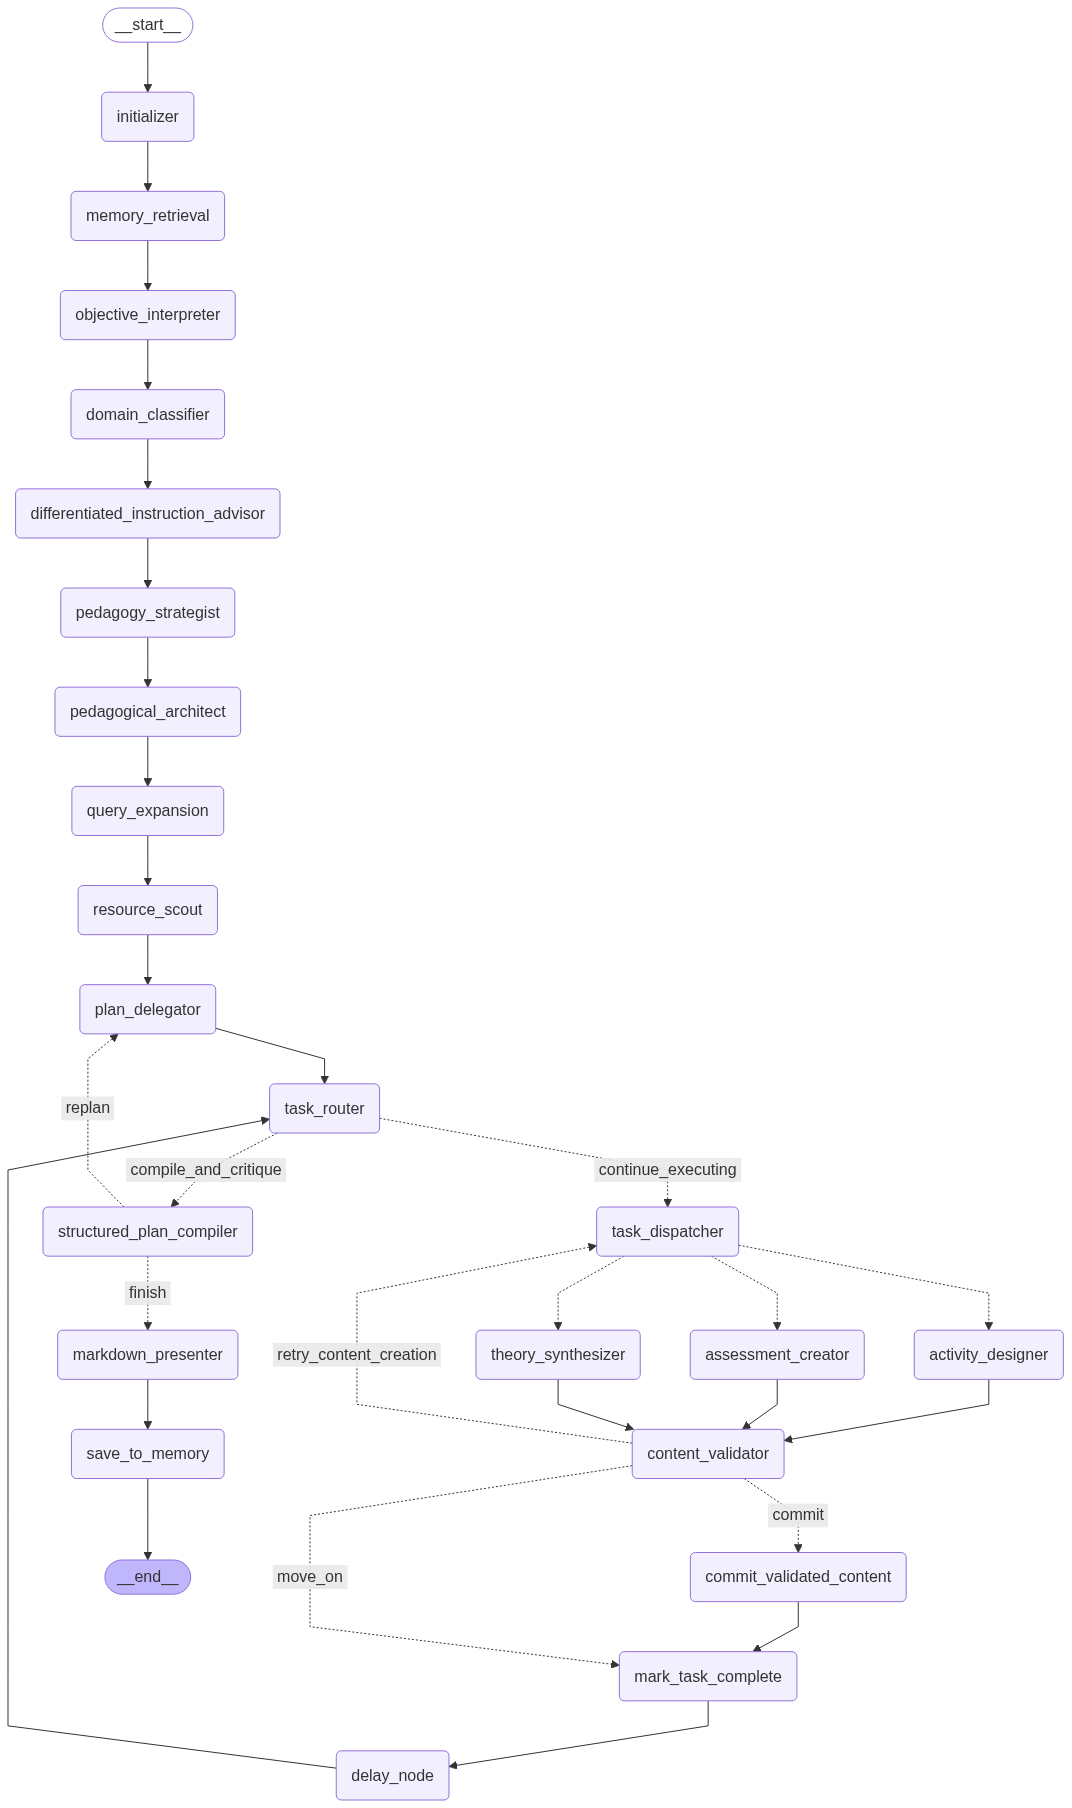

In [36]:
# ==============================================================================
# CELL 4.4: HI·ªÇN TH·ªä S∆† ƒê·ªí GRAPH 
# ==============================================================================
try:
    # L·ªánh n√†y s·∫Ω v·∫Ω m·ªôt s∆° ƒë·ªì c·ªßa workflow, r·∫•t h·ªØu √≠ch ƒë·ªÉ g·ª° l·ªói
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"L·ªói v·∫Ω bi·ªÉu ƒë·ªì: {e}. ƒê√¢y l√† l·ªói kh√¥ng nghi√™m tr·ªçng, b·∫°n v·∫´n c√≥ th·ªÉ ch·∫°y quy tr√¨nh.")

## PH·∫¶N 5

In [37]:
# ==============================================================================
# CELL 5.1: ƒê·ªäNH NGHƒ®A H√ÄM CH·∫†Y QUY TR√åNH 
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM ch∆∞a ƒë∆∞·ª£c kh·ªüi t·∫°o.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri th·ª©c ch∆∞a ƒë∆∞·ª£c t·∫£i.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' ch∆∞a ƒë∆∞·ª£c bi√™n d·ªãch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]üöÄ B·∫ÆT ƒê·∫¶U QUY TR√åNH V12.0 (HO√ÄN THI·ªÜN) V·ªöI Y√äU C·∫¶U:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Ho√†n th√†nh b∆∞·ªõc: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]üèÅ K·∫æT TH√öC QUY TR√åNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]üìù GI√ÅO √ÅN HO√ÄN CH·ªàNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON c√≥ c·∫•u tr√∫c")
        else:
            print_warning("Kh√¥ng t·∫°o ƒë∆∞·ª£c gi√°o √°n cu·ªëi c√πng. Vui l√≤ng ki·ªÉm tra log ƒë·ªÉ g·ª° l·ªói.")
            
    except Exception as e:
        print_warning(f"ƒê√£ x·∫£y ra l·ªói nghi√™m tr·ªçng trong qu√° tr√¨nh ch·∫°y graph: {e}")
        import traceback
        traceback.print_exc()

print("‚úÖ H√†m `run_architect` (v12.0) ƒë√£ s·∫µn s√†ng ƒë·ªÉ s·ª≠ d·ª•ng.")

‚úÖ H√†m `run_architect` (v12.0) ƒë√£ s·∫µn s√†ng ƒë·ªÉ s·ª≠ d·ª•ng.


In [38]:
# ==============================================================================
# CELL 5.2: K√çCH HO·∫†T CH·∫†Y TH·ª¨ NGHI·ªÜM
# ==============================================================================
# Y√™u c·∫ßu ƒë·ªÉ ki·ªÉm tra
architect_request = "So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y l√† m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao."
VERBOSE_MODE = True 

# Ch·∫°y quy tr√¨nh ƒë√£ ƒë∆∞·ª£c c·∫£i c√°ch
await run_architect(architect_request)

üöÄ B·∫ÆT ƒê·∫¶U QUY TR√åNH V12.0 (HO√ÄN THI·ªÜN) V·ªöI Y√äU C·∫¶U:
> So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y 
l√† m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao.

> `Initializer`: ƒêang kh·ªüi t·∫°o tr·∫°ng th√°i v√† l·∫•y y√™u c·∫ßu g·ªëc...

------- Ho√†n th√†nh b∆∞·ªõc: initializer -------

> `Agent: Memory Retrieval` (v9.4) ƒëang t√¨m ki·∫øm trong tr√≠ nh·ªõ...

‚úîÔ∏è T√¨m th·∫•y v√≠ d·ª• t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ:

"So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y l√† m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao."

------- Ho√†n th√†nh b∆∞·ªõc: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) ƒëang ph√¢n t√≠ch m·ª•c ti√™u...

‚úîÔ∏è M·ª•c ti√™u & R√†ng bu·ªôc ƒë√£ ph√¢n t√≠ch:

{
‚îÇ   'action_verb': 'So·∫°n',
‚îÇ   'bloom_level': 2,
‚îÇ   'topic': 'V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN',
‚îÇ   'grade_level': 'L·ªõp 9',
‚îÇ   'constraints': {
‚îÇ   ‚îÇ   'duration_minutes': 90
‚îÇ   }
}

------- Ho√†n th√†nh b∆∞·ªõc: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) ƒëang x√°c ƒë·ªãnh lƒ©nh v·ª±c chuy√™n m√¥n...

‚úîÔ∏è Lƒ©nh v·ª±c chuy√™n m√¥n ƒë∆∞·ª£c x√°c ƒë·ªãnh:

'To√°n h·ªçc'

------- Ho√†n th√†nh b∆∞·ªõc: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) ƒëang ph√¢n t√≠ch v√† ƒë·ªÅ xu·∫•t chi·∫øn l∆∞·ª£c ph√¢n h√≥a...

‚úîÔ∏è H·ªì s∆° l·ªõp h·ªçc v√† Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a:

{
‚îÇ   'learning_pace': 'ch·∫≠m',
‚îÇ   'engagement_style': 'th·ª• ƒë·ªông',
‚îÇ   'special_notes': 'L·ªõp h·ªçc kh√° y·∫øu, h·ªçc sinh d·ªÖ m·∫•t t·∫≠p trung, c·∫ßn c√°c ho·∫°t ƒë·ªông t∆∞∆°ng t√°c cao ƒë·ªÉ duy tr√¨ s·ª± ch√∫ √Ω v√† h·ª©ng th√∫.',
‚îÇ   'differentiation_strategy': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Chia nh·ªè b√†i h·ªçc th√†nh c√°c ph·∫ßn nh·ªè, s·ª≠ d·ª•ng nhi·ªÅu v√≠ d·ª• tr·ª±c quan v√† v·∫≠t th·∫≠t (m√¥ h√¨nh ƒë∆∞·ªùng tr√≤n, ƒë∆∞·ªùng th·∫≥ng). T·ªï ch·ª©c c√°c ho·∫°t ƒë·ªông nh√≥m nh·ªè v·ªõi s·ª± h∆∞·ªõng d·∫´n s√°t sao c·ªßa gi√°o vi√™n. Cung c·∫•p phi·∫øu b√†i t·∫≠p c√≥ g·ª£i √Ω, c√¥ng th·ª©c v√† c√°c b∆∞·ªõc gi·∫£i m·∫´u. Th∆∞·ªùng xuy√™n ki·ªÉm tra nhanh v√† c·ªßng c·ªë ki·∫øn th·ª©c ngay l·∫≠p t·ª©c. Cho ph√©p h·ªçc sinh tr√¨nh b√†y √Ω t∆∞·ªüng b·∫±ng h√¨nh v·∫Ω ho·∫∑c l·ªùi n√≥i tr∆∞·ªõc khi vi·∫øt.',
‚îÇ   ‚îÇ   'for_advanced_students': "Giao c√°c b√†i t·∫≠p n√¢ng cao h∆°n m·ªôt ch√∫t, y√™u c·∫ßu ch·ª©ng minh ho·∫∑c gi·∫£i th√≠ch 't·∫°i sao' m·ªôt t√≠nh ch·∫•t l·∫°i ƒë√∫ng. Khuy·∫øn kh√≠ch c√°c em t√¨m hi·ªÉu th√™m v·ªÅ ·ª©ng d·ª•ng c·ªßa v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi trong th·ª±c t·∫ø (v√≠ d·ª•: thi·∫øt k·∫ø, k·ªπ thu·∫≠t). Y√™u c·∫ßu c√°c em h·ªó tr·ª£, h∆∞·ªõng d·∫´n c√°c b·∫°n trong nh√≥m khi c·∫ßn thi·∫øt, ƒë√≥ng vai tr√≤ 'tr·ª£ gi·∫£ng' nh·ªè."
‚îÇ   }
}

------- Ho√†n th√†nh b∆∞·ªõc: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) ƒëang x√¢y d·ª±ng chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt...

‚úîÔ∏è Chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt:

{
‚îÇ   'name': 'D·∫°y h·ªçc h·ª£p t√°c (Cooperative Learning)',
‚îÇ   'rationale': 'Ph∆∞∆°ng ph√°p D·∫°y h·ªçc h·ª£p t√°c r·∫•t ph√π h·ª£p v·ªõi ƒë·∫∑c ƒëi·ªÉm c·ªßa l·ªõp h·ªçc n√†y. N√≥ gi√∫p tƒÉng c∆∞·ªùng s·ª± t∆∞∆°ng t√°c gi·ªØa h·ªçc sinh, khuy·∫øn kh√≠ch c√°c em ch·ªß ƒë·ªông tham gia v√†o qu√° tr√¨nh h·ªçc t·∫≠p thay v√¨ th·ª• ƒë·ªông l·∫Øng nghe. Vi·ªác chia nh√≥m nh·ªè cho ph√©p gi√°o vi√™n d·ªÖ d√†ng quan s√°t, h·ªó tr·ª£ k·ªãp th·ªùi cho c√°c nh√≥m y·∫øu, ƒë·ªìng th·ªùi t·∫°o c∆° h·ªôi cho h·ªçc sinh kh√°, gi·ªèi h·ªó tr·ª£ b·∫°n b√®. C√°c ho·∫°t ƒë·ªông nh√≥m v·ªõi v·∫≠t th·∫≠t v√† h√¨nh ·∫£nh tr·ª±c quan s·∫Ω duy tr√¨ s·ª± ch√∫ √Ω v√† h·ª©ng th√∫ c·ªßa h·ªçc sinh, gi√∫p c√°c em d·ªÖ d√†ng ti·∫øp thu ki·∫øn th·ª©c v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n, v·ªën l√† m·ªôt ch·ªß ƒë·ªÅ c·∫ßn s·ª± h√¨nh dung t·ªët.',
‚îÇ   'key_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu v·∫•n ƒë·ªÅ/m·ª•c ti√™u b√†i h·ªçc m·ªôt c√°ch tr·ª±c quan, h·∫•p d·∫´n.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c l·ªõp th√†nh c√°c nh√≥m h·ªçc t·∫≠p nh·ªè, c√≥ s·ª± ph√¢n h√≥a v·ªÅ nƒÉng l·ª±c.',
‚îÇ   ‚îÇ   'Giao nhi·ªám v·ª• c·ª• th·ªÉ cho t·ª´ng nh√≥m, khuy·∫øn kh√≠ch s·ª≠ d·ª•ng v·∫≠t th·∫≠t (m√¥ h√¨nh ƒë∆∞·ªùng tr√≤n, ƒë∆∞·ªùng th·∫≥ng) ho·∫∑c h√¨nh ·∫£nh ƒë·ªÉ kh√°m ph√° c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi.',
‚îÇ   ‚îÇ   'H·ªçc sinh l√†m vi·ªác nh√≥m, th·∫£o lu·∫≠n, v·∫Ω h√¨nh, ghi ch√©p k·∫øt qu·∫£ d∆∞·ªõi s·ª± h∆∞·ªõng d·∫´n c·ªßa gi√°o vi√™n.',
‚îÇ   ‚îÇ   'ƒê·∫°i di·ªán nh√≥m tr√¨nh b√†y k·∫øt qu·∫£, c√°c nh√≥m kh√°c l·∫Øng nghe v√† ƒë·∫∑t c√¢u h·ªèi.',
‚îÇ   ‚îÇ   'Gi√°o vi√™n t·ªïng k·∫øt, chu·∫©n h√≥a ki·∫øn th·ª©c, nh·∫•n m·∫°nh c√°c kh√°i ni·ªám v√† t√≠nh ch·∫•t quan tr·ªçng.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c ho·∫°t ƒë·ªông luy·ªán t·∫≠p, c·ªßng c·ªë ki·∫øn th·ª©c th√¥ng qua c√°c b√†i t·∫≠p v·∫≠n d·ª•ng.'
‚îÇ   ]
}

------- Ho√†n th√†nh b∆∞·ªõc: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) ƒëang thi·∫øt k·∫ø k·ªãch b·∫£n bu·ªïi h·ªçc...

‚úîÔ∏è B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m ƒë√£ ƒë∆∞·ª£c t·∫°o:

[
‚îÇ   'Kh·ªüi ƒë·ªông v√† Kh√°m ph√° tr·ª±c quan: Gi√°o vi√™n s·ª≠ d·ª•ng v·∫≠t th·∫≠t (v√≠ d·ª•: v√≤ng tr√≤n, th∆∞·ªõc k·∫ª) ho·∫∑c h√¨nh ·∫£nh/video minh h·ªça ƒë·ªÉ ƒë·∫∑t v·∫•n ƒë·ªÅ. T·ªï ch·ª©c ho·∫°t ƒë·ªông "D·ª± ƒëo√°n nhanh" theo c·∫∑p/nh√≥m nh·ªè, y√™u c·∫ßu h·ªçc sinh v·∫Ω ho·∫∑c m√¥ t·∫£ c√°c tr∆∞·ªùng h·ª£p ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n c√≥ th·ªÉ g·∫∑p nhau.',
‚îÇ   'X√¢y d·ª±ng ki·∫øn th·ª©c: C√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi v√† d·∫•u hi·ªáu nh·∫≠n bi·∫øt: Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè. M·ªói nh√≥m ƒë∆∞·ª£c cung c·∫•p phi·∫øu h·ªçc t·∫≠p c√≥ h√¨nh v·∫Ω/m√¥ h√¨nh ƒë∆∞·ªùng tr√≤n v√† ƒë∆∞·ªùng th·∫≥ng. Y√™u c·∫ßu c√°c nh√≥m th·ª±c hi·ªán ƒëo ƒë·∫°c (n·∫øu c√≥ m√¥ h√¨nh) ho·∫∑c ph√¢n t√≠ch h√¨nh v·∫Ω ƒë·ªÉ x√°c ƒë·ªãnh m·ªëi quan h·ªá gi·ªØa kho·∫£ng c√°ch t·ª´ t√¢m ƒë·∫øn ƒë∆∞·ªùng th·∫≥ng (d) v√† b√°n k√≠nh (R) trong t·ª´ng tr∆∞·ªùng h·ª£p. Th·∫£o lu·∫≠n nh√≥m ƒë·ªÉ r√∫t ra k·∫øt lu·∫≠n v√† ho√†n th√†nh b·∫£ng t·ªïng h·ª£p. Gi√°o vi√™n ƒëi l·∫°i h·ªó tr·ª£, ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü v√† chu·∫©n h√≥a ki·∫øn th·ª©c sau khi c√°c nh√≥m tr√¨nh b√†y.',
‚îÇ   'Luy·ªán t·∫≠p v√† V·∫≠n d·ª•ng c∆° b·∫£n: Gi√°o vi√™n giao c√°c b√†i t·∫≠p v·∫≠n d·ª•ng (c√≥ th·ªÉ l√† b√†i t·∫≠p tr·∫Øc nghi·ªám, ƒëi·ªÅn khuy·∫øt ho·∫∑c b√†i t·∫≠p t√≠nh to√°n ƒë∆°n gi·∫£n) cho c√°c nh√≥m. C√°c nh√≥m c√πng nhau th·∫£o lu·∫≠n v√† gi·∫£i quy·∫øt b√†i t·∫≠p. Gi√°o vi√™n quan s√°t, h·ªó tr·ª£ c√°c nh√≥m y·∫øu v√† khuy·∫øn kh√≠ch h·ªçc sinh kh√° h∆∞·ªõng d·∫´n b·∫°n. M·ªùi ƒë·∫°i di·ªán m·ªôt s·ªë nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ v√† gi·∫£i th√≠ch.',
‚îÇ   'T·ªïng k·∫øt v√† Giao nhi·ªám v·ª• v·ªÅ nh√†: Gi√°o vi√™n t·ªï ch·ª©c ho·∫°t ƒë·ªông "T√≥m t·∫Øt 3-2-1" (3 ƒëi·ªÅu h·ªçc ƒë∆∞·ª£c, 2 ƒëi·ªÅu c√≤n th·∫Øc m·∫Øc, 1 ƒëi·ªÅu mu·ªën t√¨m hi·ªÉu th√™m) ho·∫∑c y√™u c·∫ßu c√°c nh√≥m l·∫≠p s∆° ƒë·ªì t∆∞ duy nhanh v·ªÅ b√†i h·ªçc. Gi√°o vi√™n t·ªïng k·∫øt c√°c √Ω ch√≠nh, gi·∫£i ƒë√°p th·∫Øc m·∫Øc v√† giao b√†i t·∫≠p v·ªÅ nh√†, khuy·∫øn kh√≠ch h·ªçc sinh t√¨m ki·∫øm c√°c v√≠ d·ª• th·ª±c t·∫ø v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n.'
]

------- Ho√†n th√†nh b∆∞·ªõc: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) ƒëang ph√¢n t√≠ch y√™u c·∫ßu...

‚úîÔ∏è C√°c truy v·∫•n t√¨m ki·∫øm ƒë√£ ƒë∆∞·ª£c m·ªü r·ªông:

[
‚îÇ   'V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'L√Ω thuy·∫øt v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'B√†i t·∫≠p v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'C√¥ng th·ª©c t√≠nh kho·∫£ng c√°ch t·ª´ t√¢m ƒë·∫øn ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'ƒê∆∞·ªùng th·∫≥ng ti·∫øp x√∫c ƒë∆∞·ªùng tr√≤n ƒëi·ªÅu ki·ªán',
‚îÇ   'Gi·∫£i b√†i t·∫≠p v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi ƒë∆∞·ªùng th·∫≥ng ƒë∆∞·ªùng tr√≤n l·ªõp 9',
‚îÇ   'Chuy√™n ƒë·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'C√°c tr∆∞·ªùng h·ª£p v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'Ph∆∞∆°ng ph√°p gi·∫£i b√†i t·∫≠p v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi ƒë∆∞·ªùng th·∫≥ng ƒë∆∞·ªùng tr√≤n',
‚îÇ   'V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi ƒë∆∞·ªùng th·∫≥ng ƒë∆∞·ªùng tr√≤n c√≥ l·ªùi gi·∫£i chi ti·∫øt'
]

------- Ho√†n th√†nh b∆∞·ªõc: query_expansion -------

> `Agent: Resource Scout` (v8.1 - S·ª≠a l·ªói) ƒëang t√¨m ki·∫øm v√† s√†ng l·ªçc...

> T√¨m th·∫•y 50 t√†i li·ªáu, s√†ng l·ªçc c√≤n 8 ƒëo·∫°n vƒÉn b·∫£n ƒë·ªôc nh·∫•t.

‚úîÔ∏è T√†i li·ªáu RAG cu·ªëi c√πng:

{
‚îÇ   'source': 'S√°ch gi√°o khoa (t·ª´ RAG - ƒë√£ s√†ng l·ªçc)',
‚îÇ   'summary': 'Ch√†o c√°c em,\n\nH√¥m nay, ch√∫ng ta s·∫Ω c√πng nhau t√≥m t·∫Øt ki·∫øn th·ª©c c·ªët l√µi v·ªÅ ch·ªß ƒë·ªÅ "V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN" d·ª±a tr√™n c√°c t√†i li·ªáu ch√∫ng ta ƒë√£ h·ªçc nh√©.\n\nSau khi xem x√©t k·ªπ l∆∞·ª°ng c√°c ƒëo·∫°n vƒÉn b·∫£n ƒë∆∞·ª£c cung c·∫•p, th·∫ßy/c√¥ nh·∫≠n th·∫•y r·∫±ng **th√¥ng tin c·ª• th·ªÉ v·ªÅ "V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN" (nh∆∞ c√°c tr∆∞·ªùng h·ª£p ƒë∆∞·ªùng th·∫≥ng c·∫Øt ƒë∆∞·ªùng tr√≤n t·∫°i hai ƒëi·ªÉm, ti·∫øp x√∫c v·ªõi ƒë∆∞·ªùng tr√≤n, hay kh√¥ng c·∫Øt ƒë∆∞·ªùng tr√≤n) kh√¥ng c√≥ trong t√†i li·ªáu tham kh·∫£o n√†y.**\n\nDo ƒë√≥, th·∫ßy/c√¥ kh√¥ng th·ªÉ t√≥m t·∫Øt ki·∫øn th·ª©c c·ªët l√µi v·ªÅ ch·ªß ƒë·ªÅ n√†y d·ª±a tr√™n c√°c ƒëo·∫°n vƒÉn b·∫£n ƒë√£ cho. ƒê·ªÉ hi·ªÉu r√µ h∆°n v·ªÅ "V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN", ch√∫ng ta s·∫Ω c·∫ßn tham kh·∫£o th√™m c√°c ngu·ªìn t√†i li·ªáu kh√°c nh√© c√°c em.'
}

------- Ho√†n th√†nh b∆∞·ªõc: resource_scout -------

> `Agent: Headmaster Delegator` (v13.1 - Giao vi·ªác Th√¥ng minh) ƒëang ch·ªâ ƒë·∫°o...

‚úîÔ∏è ƒê√£ t·∫°o 5 nhi·ªám v·ª• v·ªõi ch·ªâ d·∫´n chi ti·∫øt:

[
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 0,
‚îÇ   ‚îÇ   'task_name': 'Kh·ªüi ƒë·ªông v√† ƒê·∫∑t v·∫•n ƒë·ªÅ v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n s·ª≠ d·ª•ng v·∫≠t th·∫≠t ho·∫∑c h√¨nh ·∫£nh/video ƒë·ªÉ gi·ªõi thi·ªáu ch·ªß ƒë·ªÅ. T·ªï ch·ª©c ho·∫°t ƒë·ªông "D·ª± ƒëo√°n nhanh" theo c·∫∑p/nh√≥m nh·ªè, y√™u c·∫ßu h·ªçc sinh v·∫Ω ho·∫∑c m√¥ t·∫£ c√°c tr∆∞·ªùng h·ª£p ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n c√≥ th·ªÉ g·∫∑p nhau.',
‚îÇ   ‚îÇ   'estimated_duration': 15,
‚îÇ   ‚îÇ   'guidance': 'Chu·∫©n b·ªã v·∫≠t th·∫≠t/h√¨nh ·∫£nh, t·ªï ch·ª©c ho·∫°t ƒë·ªông d·ª± ƒëo√°n, thu th·∫≠p √Ω t∆∞·ªüng ban ƒë·∫ßu c·ªßa h·ªçc sinh.',
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 1,
‚îÇ   ‚îÇ   'task_name': 'Kh√°m ph√° v√† X√¢y d·ª±ng ki·∫øn th·ª©c v·ªÅ c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi',
‚îÇ   ‚îÇ   'task_description': 'Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè. M·ªói nh√≥m ƒë∆∞·ª£c cung c·∫•p phi·∫øu h·ªçc t·∫≠p c√≥ h√¨nh v·∫Ω/m√¥ h√¨nh ƒë∆∞·ªùng tr√≤n v√† ƒë∆∞·ªùng th·∫≥ng. Y√™u c·∫ßu c√°c nh√≥m ph√¢n t√≠ch h√¨nh v·∫Ω/m√¥ h√¨nh ƒë·ªÉ x√°c ƒë·ªãnh m·ªëi quan h·ªá gi·ªØa kho·∫£ng c√°ch t·ª´ t√¢m ƒë·∫øn ƒë∆∞·ªùng th·∫≥ng (d) v√† b√°n k√≠nh (R) trong t·ª´ng tr∆∞·ªùng h·ª£p.',
‚îÇ   ‚îÇ   'estimated_duration': 30,
‚îÇ   ‚îÇ   'guidance': 'H∆∞·ªõng d·∫´n nh√≥m ph√¢n t√≠ch, ƒëo ƒë·∫°c (n·∫øu c√≥), v√† ghi nh·∫≠n m·ªëi quan h·ªá d v√† R.',
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 2,
‚îÇ   ‚îÇ   'task_name': 'Th·∫£o lu·∫≠n nh√≥m v√† Chu·∫©n h√≥a ki·∫øn th·ª©c',
‚îÇ   ‚îÇ   'task_description': 'C√°c nh√≥m th·∫£o lu·∫≠n ƒë·ªÉ r√∫t ra k·∫øt lu·∫≠n v√† ho√†n th√†nh b·∫£ng t·ªïng h·ª£p v·ªÅ c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n. Gi√°o vi√™n ƒëi l·∫°i h·ªó tr·ª£, ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü v√† chu·∫©n h√≥a ki·∫øn th·ª©c sau khi c√°c nh√≥m tr√¨nh b√†y k·∫øt qu·∫£.',
‚îÇ   ‚îÇ   'estimated_duration': 15,
‚îÇ   ‚îÇ   'guidance': 'T·ªï ch·ª©c th·∫£o lu·∫≠n nh√≥m, chu·∫©n h√≥a ki·∫øn th·ª©c d·ª±a tr√™n k·∫øt qu·∫£ c·ªßa h·ªçc sinh.',
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 3,
‚îÇ   ‚îÇ   'task_name': 'Luy·ªán t·∫≠p v√† V·∫≠n d·ª•ng c√°c ki·∫øn th·ª©c c∆° b·∫£n',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n giao c√°c b√†i t·∫≠p v·∫≠n d·ª•ng (tr·∫Øc nghi·ªám, ƒëi·ªÅn khuy·∫øt, t√≠nh to√°n ƒë∆°n gi·∫£n) cho c√°c nh√≥m. C√°c nh√≥m c√πng nhau th·∫£o lu·∫≠n v√† gi·∫£i quy·∫øt b√†i t·∫≠p. M·ªùi ƒë·∫°i di·ªán m·ªôt s·ªë nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ v√† gi·∫£i th√≠ch.',
‚îÇ   ‚îÇ   'estimated_duration': 20,
‚îÇ   ‚îÇ   'guidance': 'Giao b√†i t·∫≠p, h·ªó tr·ª£ nh√≥m y·∫øu, khuy·∫øn kh√≠ch h·ªçc sinh tr√¨nh b√†y.',
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 4,
‚îÇ   ‚îÇ   'task_name': 'T·ªïng k·∫øt b√†i h·ªçc v√† Giao nhi·ªám v·ª• v·ªÅ nh√†',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n t·ªï ch·ª©c ho·∫°t ƒë·ªông "T√≥m t·∫Øt 3-2-1" ho·∫∑c y√™u c·∫ßu c√°c nh√≥m l·∫≠p s∆° ƒë·ªì t∆∞ duy nhanh v·ªÅ b√†i h·ªçc. Gi√°o vi√™n t·ªïng k·∫øt c√°c √Ω ch√≠nh, gi·∫£i ƒë√°p th·∫Øc m·∫Øc v√† giao b√†i t·∫≠p v·ªÅ nh√†, khuy·∫øn kh√≠ch h·ªçc sinh t√¨m ki·∫øm c√°c v√≠ d·ª• th·ª±c t·∫ø.',
‚îÇ   ‚îÇ   'estimated_duration': 10,
‚îÇ   ‚îÇ   'guidance': 'T·ªï ch·ª©c ho·∫°t ƒë·ªông t·ªïng k·∫øt, gi·∫£i ƒë√°p th·∫Øc m·∫Øc, giao b√†i t·∫≠p v·ªÅ nh√†.',
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   }
]

------- Ho√†n th√†nh b∆∞·ªõc: plan_delegator -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Kh·ªüi ƒë·ªông v√† ƒê·∫∑t v·∫•n ƒë·ªÅ v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi' (ID: 0)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông: V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa c√°c v·∫≠t th·ªÉ',
‚îÇ   'duration_minutes': 15,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Chu·∫©n b·ªã v·∫≠t th·∫≠t/h√¨nh ·∫£nh minh h·ªça ƒëa d·∫°ng v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi (v√≠ d·ª•: b√∫t tr√™n s√°ch, h·ªôp b√∫t b√™n c·∫°nh th∆∞·ªõc, qu·∫£ b√≥ng trong h·ªôp).',
‚îÇ   ‚îÇ   'Ph·ªï bi·∫øn lu·∫≠t ch∆°i/y√™u c·∫ßu ho·∫°t ƒë·ªông cho h·ªçc sinh, ƒë·∫£m b·∫£o c√°c em hi·ªÉu r√µ nhi·ªám v·ª• m√¥ t·∫£ v·ªã tr√≠.',
‚îÇ   ‚îÇ   'Quan s√°t, l·∫Øng nghe c√°c nh√≥m th·∫£o lu·∫≠n v√† ghi nh·∫≠n c√°c √Ω t∆∞·ªüng ban ƒë·∫ßu, c√°c t·ª´ ng·ªØ m√† h·ªçc sinh s·ª≠ d·ª•ng ƒë·ªÉ m√¥ t·∫£ v·ªã tr√≠.',
‚îÇ   ‚îÇ   'G·ª£i √Ω, ƒë·∫∑t c√¢u h·ªèi m·ªü ƒë·ªÉ khuy·∫øn kh√≠ch h·ªçc sinh m√¥ t·∫£ chi ti·∫øt h∆°n (v√≠ d·ª•: "B√∫t ·ªü ƒë√¢u so v·ªõi s√°ch?", "C√≥ c√°ch n√†o kh√°c ƒë·ªÉ n√≥i v·ªÅ v·ªã tr√≠ c·ªßa h·ªôp b√∫t v√† th∆∞·ªõc kh√¥ng?").',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c cho c√°c nh√≥m chia s·∫ª v√† t·ªïng h·ª£p c√°c c√°ch di·ªÖn ƒë·∫°t v·ªÅ v·ªã tr√≠.',
‚îÇ   ‚îÇ   'D·∫´n d·∫Øt h·ªçc sinh nh·∫≠n ra s·ª± ƒëa d·∫°ng trong c√°ch di·ªÖn ƒë·∫°t v√† s·ª± c·∫ßn thi·∫øt c·ªßa m·ªôt ng√¥n ng·ªØ chung, ch√≠nh x√°c ƒë·ªÉ m√¥ t·∫£ v·ªã tr√≠, t·ª´ ƒë√≥ ƒë·∫∑t v·∫•n ƒë·ªÅ cho b√†i h·ªçc m·ªõi.'
‚îÇ   ],
‚îÇ   'extension_component': 'H·ªçc sinh c√≥ th·ªÉ t·ª± s·∫Øp x·∫øp c√°c v·∫≠t th·ªÉ theo √Ω m√¨nh v√† y√™u c·∫ßu b·∫°n c√πng nh√≥m m√¥ t·∫£ v·ªã tr√≠, sau ƒë√≥ so s√°nh c√°c c√°ch di·ªÖn ƒë·∫°t v√† t√¨m ra ƒëi·ªÉm chung/kh√°c bi·ªát.',
‚îÇ   'solution_guide': "Kh√¥ng c√≥ 'ƒë√°p √°n' c·ª• th·ªÉ trong ho·∫°t ƒë·ªông n√†y. M·ª•c ti√™u l√† thu th·∫≠p c√°c √Ω t∆∞·ªüng ban ƒë·∫ßu v√† c√°c c√°ch di·ªÖn ƒë·∫°t t·ª± nhi√™n c·ªßa h·ªçc sinh v·ªÅ v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi. Gi√°o vi√™n c·∫ßn ghi nh·∫≠n c√°c t·ª´ kh√≥a nh∆∞ 'tr√™n', 'd∆∞·ªõi', 'b√™n c·∫°nh', 'trong', 'ngo√†i', 'gi·ªØa', 'ph√≠a tr∆∞·ªõc', 'ph√≠a sau' ƒë·ªÉ l√†m n·ªÅn t·∫£ng cho vi·ªác h√¨nh th√†nh kh√°i ni·ªám sau n√†y.",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n c√≥ th·ªÉ cung c·∫•p c√°c c√¢u h·ªèi g·ª£i √Ω c·ª• th·ªÉ h∆°n ho·∫∑c ch·ªâ ƒë·ªãnh c√°c c·∫∑p v·∫≠t th·ªÉ ƒë∆°n gi·∫£n ƒë·ªÉ h·ªçc sinh d·ªÖ d√†ng m√¥ t·∫£. C√≥ th·ªÉ cho h·ªçc sinh s·ª≠ d·ª•ng c·ª≠ ch·ªâ ƒë·ªÉ di·ªÖn t·∫£ v·ªã tr√≠ tr∆∞·ªõc khi d√πng l·ªùi.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh s·ª≠ d·ª•ng nhi·ªÅu t·ª´ ng·ªØ kh√°c nhau ƒë·ªÉ m√¥ t·∫£ c√πng m·ªôt v·ªã tr√≠, ho·∫∑c ƒë·∫∑t ra t√¨nh hu·ªëng ph·ª©c t·∫°p h∆°n v·ªõi nhi·ªÅu v·∫≠t th·ªÉ ƒë·ªÉ m√¥ t·∫£ m·ªëi quan h·ªá gi·ªØa ch√∫ng. C√≥ th·ªÉ y√™u c·∫ßu h·ªçc sinh t·ª± t·∫°o ra m·ªôt t√¨nh hu·ªëng v√† m√¥ t·∫£.'
‚îÇ   },
‚îÇ   'question_or_description': 'Gi√°o vi√™n chu·∫©n b·ªã m·ªôt s·ªë v·∫≠t th·∫≠t (v√≠ d·ª•: b√∫t, s√°ch, h·ªôp b√∫t, th∆∞·ªõc k·∫ª) ho·∫∑c h√¨nh ·∫£nh c√°c v·∫≠t th·ªÉ ƒë∆∞·ª£c s·∫Øp x·∫øp theo nhi·ªÅu v·ªã tr√≠ kh√°c nhau (tr√™n, d∆∞·ªõi, b√™n c·∫°nh, gi·ªØa, trong, ngo√†i). Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè (3-4 h·ªçc sinh). Gi√°o vi√™n tr√¨nh b√†y c√°c v·∫≠t th·∫≠t/h√¨nh ·∫£nh. Y√™u c·∫ßu c√°c nh√≥m quan s√°t v√† m√¥ t·∫£ v·ªã tr√≠ c·ªßa c√°c v·∫≠t th·ªÉ n√†y so v·ªõi nhau b·∫±ng ng√¥n ng·ªØ t·ª± nhi√™n c·ªßa m√¨nh. C√°c nh√≥m ghi l·∫°i c√°c m√¥ t·∫£ v√† d·ª± ƒëo√°n c·ªßa m√¨nh. ƒê·∫°i di·ªán m·ªôt s·ªë nh√≥m tr√¨nh b√†y k·∫øt qu·∫£.',
‚îÇ   'content_type': 'Ho·∫°t ƒë·ªông d·ª± ƒëo√°n v√† th·∫£o lu·∫≠n nh√≥m'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...

> ‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: Ho·∫°t ƒë·ªông n√†y r·∫•t hay v√† c√≥ t√≠nh t∆∞∆°ng t√°c cao, gi√∫p h·ªçc sinh kh·ªüi
ƒë·ªông b√†i h·ªçc m·ªôt c√°ch t·ª± nhi√™n. Tuy nhi√™n, v·ªõi 15 ph√∫t, ho·∫°t ƒë·ªông c√≥ th·ªÉ h∆°i tham v·ªçng m·ªôt ch√∫t, ƒë·∫∑c bi·ªát l√† ph·∫ßn 
chia s·∫ª c·ªßa c√°c nh√≥m v√† t·ªïng h·ª£p. Gi√°o vi√™n c·∫ßn qu·∫£n l√Ω th·ªùi gian th·∫≠t ch·∫∑t ch·∫Ω, c√≥ th·ªÉ gi·ªõi h·∫°n s·ªë l∆∞·ª£ng nh√≥m chia
s·∫ª ho·∫∑c ch·ªâ t·∫≠p trung v√†o m·ªôt v√†i v√≠ d·ª• ƒëi·ªÉn h√¨nh ƒë·ªÉ ƒë·∫£m b·∫£o ho√†n th√†nh ƒë√∫ng ti·∫øn ƒë·ªô. C√°c ph·∫ßn m·ªü r·ªông v√† ph√¢n h√≥a 
c√≥ th·ªÉ ƒë∆∞·ª£c √°p d·ª•ng linh ho·∫°t t√πy theo th·ªùi gian th·ª±c t·∫ø v√† ƒë·ªëi t∆∞·ª£ng h·ªçc sinh.)

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Kh√°m ph√° v√† X√¢y d·ª±ng ki·∫øn th·ª©c v·ªÅ c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi' (ID: 1)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° v√† X√¢y d·ª±ng ki·∫øn th·ª©c v·ªÅ c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n',
‚îÇ   'duration_minutes': 30,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu nhi·ªám v·ª•, chia l·ªõp th√†nh c√°c nh√≥m nh·ªè (3-4 h·ªçc sinh) v√† ph√°t d·ª•ng c·ª• (gi·∫•y, b√∫t, compa, th∆∞·ªõc k·∫ª).',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n c√°c nh√≥m th·ª±c hi·ªán vi·ªác v·∫Ω v√† ƒëo ƒë·∫°c, ƒë·∫£m b·∫£o h·ªçc sinh hi·ªÉu r√µ c√°ch x√°c ƒë·ªãnh d v√† R.',
‚îÇ   ‚îÇ   "Quan s√°t, ƒëi l·∫°i gi·ªØa c√°c nh√≥m ƒë·ªÉ h·ªó tr·ª£, gi·∫£i ƒë√°p th·∫Øc m·∫Øc v√† g·ª£i √Ω khi c·∫ßn thi·∫øt (v√≠ d·ª•: 'C√°c em ƒë√£ th·ª≠ v·∫Ω tr∆∞·ªùng h·ª£p ƒë∆∞·ªùng th·∫≥ng ƒëi qua t√¢m ch∆∞a?').",
‚îÇ   ‚îÇ   'Y√™u c·∫ßu ƒë·∫°i di·ªán 1-2 nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ v√† k·∫øt lu·∫≠n c·ªßa nh√≥m m√¨nh.',
‚îÇ   ‚îÇ   'T·ªïng h·ª£p c√°c k·∫øt qu·∫£, ch·ªët ki·∫øn th·ª©c v·ªÅ m·ªëi quan h·ªá gi·ªØa d v√† R ·ª©ng v·ªõi t·ª´ng v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n.'
‚îÇ   ],
‚îÇ   'extension_component': 'V·∫Ω th√™m c√°c tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát nh∆∞ ƒë∆∞·ªùng th·∫≥ng ƒëi qua t√¢m ƒë∆∞·ªùng tr√≤n. T√¨m c√°c v√≠ d·ª• th·ª±c t·∫ø trong cu·ªôc s·ªëng v·ªÅ c√°c v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi n√†y (v√≠ d·ª•: b√°nh xe lƒÉn tr√™n ƒë∆∞·ªùng, m·∫∑t tr·ªùi m·ªçc/l·∫∑n so v·ªõi ƒë∆∞·ªùng ch√¢n tr·ªùi).',
‚îÇ   'solution_guide': "C√°c m·ªëi quan h·ªá c·∫ßn r√∫t ra: d < R (ƒë∆∞·ªùng th·∫≥ng c·∫Øt ƒë∆∞·ªùng tr√≤n t·∫°i hai ƒëi·ªÉm), d = R (ƒë∆∞·ªùng th·∫≥ng ti·∫øp x√∫c ƒë∆∞·ªùng tr√≤n t·∫°i m·ªôt ƒëi·ªÉm), d > R (ƒë∆∞·ªùng th·∫≥ng kh√¥ng c·∫Øt ƒë∆∞·ªùng tr√≤n). G·ª£i √Ω: 'Kho·∫£ng c√°ch d l√† g√¨?', 'B√°n k√≠nh R l√† g√¨?', 'Khi n√†o ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n c√≥ ƒëi·ªÉm chung?'",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p c√°c h√¨nh v·∫Ω m·∫´u ho·∫∑c h∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ c√°ch v·∫Ω v√† ƒëo ƒë·∫°c. Gi√°o vi√™n c√≥ th·ªÉ l√†m vi·ªác tr·ª±c ti·∫øp v·ªõi nh√≥m n√†y ƒë·ªÉ ƒë·∫£m b·∫£o h·ªç hi·ªÉu kh√°i ni·ªám d v√† R.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh gi·∫£i th√≠ch t·∫°i sao m·ªëi quan h·ªá d v√† R l·∫°i quy·∫øt ƒë·ªãnh v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi. Th·ª≠ th√°ch c√°c em t√¨m th√™m c√°c tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát ho·∫∑c m·ªü r·ªông sang v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa hai ƒë∆∞·ªùng tr√≤n (n·∫øu th·ªùi gian cho ph√©p).'
‚îÇ   },
‚îÇ   'question_or_description': 'M·ªói nh√≥m s·ª≠ d·ª•ng compa v√† th∆∞·ªõc ƒë·ªÉ v·∫Ω c√°c tr∆∞·ªùng h·ª£p v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n (c·∫Øt nhau, ti·∫øp x√∫c, kh√¥ng c·∫Øt nhau). Sau ƒë√≥, ƒëo kho·∫£ng c√°ch t·ª´ t√¢m ƒë∆∞·ªùng tr√≤n ƒë·∫øn ƒë∆∞·ªùng th·∫≥ng (d) v√† b√°n k√≠nh (R) trong t·ª´ng tr∆∞·ªùng h·ª£p. Ghi nh·∫≠n v√† so s√°nh m·ªëi quan h·ªá gi·ªØa d v√† R, t·ª´ ƒë√≥ r√∫t ra k·∫øt lu·∫≠n v·ªÅ ƒëi·ªÅu ki·ªán cho m·ªói v·ªã tr√≠ t∆∞∆°ng ƒë·ªëi.',
‚îÇ   'content_type': 'Th·∫£o lu·∫≠n nh√≥m v√† Th·ª±c h√†nh'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...

> ‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: Ho·∫°t ƒë·ªông n√†y ƒë∆∞·ª£c thi·∫øt k·∫ø r·∫•t t·ªët, khuy·∫øn kh√≠ch h·ªçc sinh t·ª± kh√°m
ph√° ki·∫øn th·ª©c m·ªôt c√°ch ch·ªß ƒë·ªông. Tuy nhi√™n, v·ªõi 30 ph√∫t, vi·ªác ho√†n th√†nh t·∫•t c·∫£ c√°c b∆∞·ªõc t·ª´ v·∫Ω, ƒëo ƒë·∫°c, tr√¨nh b√†y, 
t·ªïng k·∫øt, v√† ƒë·∫∑c bi·ªát l√† c√°c ph·∫ßn m·ªü r·ªông v√† ph√¢n h√≥a c√≥ th·ªÉ s·∫Ω kh√° th√°ch th·ª©c. Gi√°o vi√™n c·∫ßn qu·∫£n l√Ω th·ªùi gian 
th·∫≠t ch·∫∑t ch·∫Ω, c√≥ th·ªÉ ∆∞u ti√™n ph·∫ßn kh√°m ph√° ch√≠nh v√† r√∫t g·ªçn th·ªùi gian tr√¨nh b√†y ho·∫∑c coi ph·∫ßn m·ªü r·ªông l√† nhi·ªám v·ª• 
v·ªÅ nh√†/n√¢ng cao cho h·ªçc sinh ho√†n th√†nh sau ƒë·ªÉ ƒë·∫£m b·∫£o k·ªãp ti·∫øn ƒë·ªô.)

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Th·∫£o lu·∫≠n nh√≥m v√† Chu·∫©n h√≥a ki·∫øn th·ª©c' (ID: 2)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Th·∫£o lu·∫≠n nh√≥m v√† Chu·∫©n h√≥a ki·∫øn th·ª©c',
‚îÇ   'duration_minutes': 15,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu nhi·ªám v·ª• th·∫£o lu·∫≠n v√† ph√¢n chia th·ªùi gian c·ª• th·ªÉ cho t·ª´ng ph·∫ßn (th·∫£o lu·∫≠n nh√≥m, tr√¨nh b√†y, t·ªïng k·∫øt).',
‚îÇ   ‚îÇ   'Quan s√°t c√°c nh√≥m l√†m vi·ªác, l·∫Øng nghe, g·ª£i √Ω khi c·∫ßn thi·∫øt (kh√¥ng can thi·ªáp s√¢u v√†o n·ªôi dung th·∫£o lu·∫≠n ch√≠nh).',
‚îÇ   ‚îÇ   'M·ªùi ƒë·∫°i di·ªán c√°c nh√≥m tr√¨nh b√†y nhanh k·∫øt qu·∫£.',
‚îÇ   ‚îÇ   'T·ªïng h·ª£p c√°c √Ω ki·∫øn, chu·∫©n h√≥a ki·∫øn th·ª©c tr·ªçng t√¢m, l√†m r√µ c√°c ƒëi·ªÉm c√≤n m∆° h·ªì ho·∫∑c sai s√≥t d·ª±a tr√™n k·∫øt qu·∫£ c·ªßa h·ªçc sinh.',
‚îÇ   ‚îÇ   'Kh·∫≥ng ƒë·ªãnh l·∫°i c√°c ki·∫øn th·ª©c c·ªët l√µi v√† ch·ªët l·∫°i v·∫•n ƒë·ªÅ h·ªçc t·∫≠p.'
‚îÇ   ],
‚îÇ   'extension_component': 'H·ªçc sinh ho√†n th√†nh s·ªõm c√≥ th·ªÉ chu·∫©n b·ªã th√™m c√°c v√≠ d·ª• minh h·ªça kh√°c cho ki·∫øn th·ª©c v·ª´a ƒë∆∞·ª£c chu·∫©n h√≥a, ho·∫∑c suy nghƒ© v·ªÅ c√°c ·ª©ng d·ª•ng th·ª±c t·∫ø c·ªßa ki·∫øn th·ª©c ƒë√≥ trong ƒë·ªùi s·ªëng.',
‚îÇ   'solution_guide': "Gi√°o vi√™n c·∫ßn c√≥ s·∫µn c√°c ƒë√°p √°n chu·∫©n ho·∫∑c c√°c lu·∫≠n ƒëi·ªÉm ch√≠nh c·∫ßn ƒë∆∞·ª£c h·ªçc sinh ƒë·∫°t t·ªõi. Chu·∫©n b·ªã c√°c c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ d·∫´n d·∫Øt h·ªçc sinh ƒë·∫øn ki·∫øn th·ª©c ƒë√∫ng n·∫øu c√°c nh√≥m g·∫∑p kh√≥ khƒÉn. V√≠ d·ª•: 'ƒêi·ªÉm m·∫•u ch·ªët c·ªßa v·∫•n ƒë·ªÅ n√†y l√† g√¨?', 'C√≥ c√°ch n√†o kh√°c ƒë·ªÉ di·ªÖn ƒë·∫°t kh√¥ng?', 'T·∫°i sao l·∫°i ch·ªçn gi·∫£i ph√°p n√†y?'",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω c√°c c√¢u h·ªèi nh·ªè h∆°n, c·ª• th·ªÉ h∆°n cho nh√≥m, ho·∫∑c cung c·∫•p m·ªôt s·ªë t·ª´ kh√≥a/kh√°i ni·ªám ƒë·ªÉ nh√≥m d·ªÖ d√†ng b·∫Øt ƒë·∫ßu th·∫£o lu·∫≠n. ƒê·∫£m b·∫£o c√°c em ƒë∆∞·ª£c tham gia v√†o qu√° tr√¨nh t·ªïng h·ª£p √Ω ki·∫øn.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Khuy·∫øn kh√≠ch c√°c nh√≥m n√†y ƒëi s√¢u h∆°n v√†o ph√¢n t√≠ch, t√¨m ra nhi·ªÅu kh√≠a c·∫°nh c·ªßa v·∫•n ƒë·ªÅ, ho·∫∑c ƒë·ªÅ xu·∫•t c√°c gi·∫£i ph√°p s√°ng t·∫°o h∆°n. Y√™u c·∫ßu c√°c em gi·∫£i th√≠ch r√µ r√†ng c∆° s·ªü l√Ω lu·∫≠n cho c√¢u tr·∫£ l·ªùi c·ªßa m√¨nh.'
‚îÇ   },
‚îÇ   'question_or_description': 'H·ªçc sinh l√†m vi·ªác theo nh√≥m (3-4 ng∆∞·ªùi) ƒë·ªÉ th·∫£o lu·∫≠n v·ªÅ m·ªôt v·∫•n ƒë·ªÅ/c√¢u h·ªèi c·ª• th·ªÉ (do gi√°o vi√™n ƒë∆∞a ra tr∆∞·ªõc ho·∫∑c trong ho·∫°t ƒë·ªông). C√°c nh√≥m t·ªïng h·ª£p √Ω ki·∫øn, th·ªëng nh·∫•t c√¢u tr·∫£ l·ªùi ho·∫∑c gi·∫£i ph√°p. Sau ƒë√≥, ƒë·∫°i di·ªán 2-3 nh√≥m s·∫Ω tr√¨nh b√†y nhanh k·∫øt qu·∫£ th·∫£o lu·∫≠n c·ªßa nh√≥m m√¨nh (m·ªói nh√≥m kho·∫£ng 1-2 ph√∫t).',
‚îÇ   'content_type': 'Th·∫£o lu·∫≠n nh√≥m, T·ªïng k·∫øt v√† Kh√°i qu√°t h√≥a'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...

> ‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: Ho·∫°t ƒë·ªông n√†y ƒë∆∞·ª£c thi·∫øt k·∫ø r·∫•t t·ªët, bao g·ªìm ƒë·∫ßy ƒë·ªß c√°c b∆∞·ªõc t·ª´ 
th·∫£o lu·∫≠n nh√≥m ƒë·∫øn chu·∫©n h√≥a ki·∫øn th·ª©c, c√≥ c·∫£ ph·∫ßn m·ªü r·ªông v√† ph√¢n h√≥a. Tuy nhi√™n, v·ªõi th·ªùi l∆∞·ª£ng 15 ph√∫t, vi·ªác 
th·ª±c hi·ªán t·∫•t c·∫£ c√°c b∆∞·ªõc m·ªôt c√°ch hi·ªáu qu·∫£ c√≥ th·ªÉ kh√° th√°ch th·ª©c. Gi√°o vi√™n c·∫ßn qu·∫£n l√Ω th·ªùi gian r·∫•t ch·∫∑t ch·∫Ω, c√≥
th·ªÉ r√∫t ng·∫Øn th·ªùi gian tr√¨nh b√†y c·ªßa c√°c nh√≥m ho·∫∑c t·∫≠p trung v√†o vi·ªác chu·∫©n h√≥a c√°c √Ω ch√≠nh nh·∫•t ƒë·ªÉ ƒë·∫£m b·∫£o ho√†n 
th√†nh trong khung th·ªùi gian cho ph√©p.)

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Luy·ªán t·∫≠p v√† V·∫≠n d·ª•ng c√°c ki·∫øn th·ª©c c∆° b·∫£n' (ID: 3)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Luy·ªán t·∫≠p v√† V·∫≠n d·ª•ng ki·∫øn th·ª©c c∆° b·∫£n',
‚îÇ   'duration_minutes': 20,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu b√†i t·∫≠p ho·∫∑c h∆∞·ªõng d·∫´n h·ªçc sinh l√†m b√†i t·∫≠p trong s√°ch gi√°o khoa.',
‚îÇ   ‚îÇ   'Quan s√°t, ƒëi l·∫°i trong l·ªõp, k·ªãp th·ªùi h·ªó tr·ª£ c√°c nh√≥m/c√° nh√¢n g·∫∑p kh√≥ khƒÉn.',
‚îÇ   ‚îÇ   'G·ª£i √Ω, ƒë·∫∑t c√¢u h·ªèi d·∫´n d·∫Øt cho h·ªçc sinh y·∫øu.',
‚îÇ   ‚îÇ   'M·ªùi 2-3 h·ªçc sinh (c√≥ th·ªÉ l√† h·ªçc sinh y·∫øu v√† h·ªçc sinh kh√°) l√™n b·∫£ng tr√¨nh b√†y ho·∫∑c chia s·∫ª c√°ch l√†m/k·∫øt qu·∫£.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c cho h·ªçc sinh nh·∫≠n x√©t, b·ªï sung b√†i l√†m c·ªßa b·∫°n.',
‚îÇ   ‚îÇ   'Ch·ªët l·∫°i ki·∫øn th·ª©c v√† ph∆∞∆°ng ph√°p gi·∫£i.'
‚îÇ   ],
‚îÇ   'extension_component': 'ƒê·ªëi v·ªõi h·ªçc sinh ho√†n th√†nh s·ªõm, c√≥ th·ªÉ l√†m th√™m b√†i t·∫≠p n√¢ng cao (1 b√†i) ho·∫∑c suy nghƒ© v·ªÅ m·ªôt c√¢u h·ªèi m·ªü r·ªông li√™n h·ªá th·ª±c t·∫ø li√™n quan ƒë·∫øn ki·∫øn th·ª©c ƒë√£ h·ªçc.',
‚îÇ   'solution_guide': 'G·ª£i √Ω c√°c b∆∞·ªõc gi·∫£i chung cho d·∫°ng b√†i t·∫≠p. Nh·∫•n m·∫°nh c√°c l·ªói th∆∞·ªùng g·∫∑p v√† c√°ch kh·∫Øc ph·ª•c. ƒê∆∞a ra c√°c c√¢u h·ªèi ki·ªÉm tra s·ª± hi·ªÉu bi·∫øt: "T·∫°i sao l·∫°i ch·ªçn ph∆∞∆°ng ph√°p n√†y?", "C√≥ c√°ch gi·∫£i n√†o kh√°c kh√¥ng?", "Ki·∫øn th·ª©c n√†y c√≥ th·ªÉ ·ª©ng d·ª•ng v√†o ƒë√¢u trong th·ª±c t·∫ø?"',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n cung c·∫•p c√°c g·ª£i √Ω c·ª• th·ªÉ, c√¥ng th·ª©c, ho·∫∑c v√≠ d·ª• m·∫´u. C√≥ th·ªÉ cho ph√©p h·ªçc sinh y·∫øu ch·ªâ l√†m m·ªôt ph·∫ßn c·ªßa b√†i t·∫≠p ho·∫∑c t·∫≠p trung v√†o c√°c c√¢u h·ªèi d·ªÖ h∆°n. H·ªó tr·ª£ tr·ª±c ti·∫øp, gi·∫£i ƒë√°p th·∫Øc m·∫Øc c√° nh√¢n.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Khuy·∫øn kh√≠ch l√†m c√°c b√†i t·∫≠p m·ªü r·ªông ho·∫∑c c√¢u h·ªèi t∆∞ duy. Y√™u c·∫ßu gi·∫£i th√≠ch s√¢u h∆°n v·ªÅ c√°ch l√†m, c√°c ph∆∞∆°ng ph√°p kh√°c nhau ho·∫∑c ·ª©ng d·ª•ng th·ª±c t·∫ø c·ªßa ki·∫øn th·ª©c. C√≥ th·ªÉ giao nhi·ªám v·ª• h·ªó tr·ª£ c√°c b·∫°n trong nh√≥m.'
‚îÇ   },
‚îÇ   'question_or_description': 'H·ªçc sinh l√†m c√°c b√†i t·∫≠p v·∫≠n d·ª•ng tr·ª±c ti·∫øp ki·∫øn th·ª©c v·ª´a h·ªçc (v√≠ d·ª•: gi·∫£i 2-3 b√†i t·∫≠p c∆° b·∫£n trong s√°ch gi√°o khoa ho·∫∑c phi·∫øu b√†i t·∫≠p). Sau ƒë√≥, h·ªçc sinh c√≥ th·ªÉ trao ƒë·ªïi nhanh k·∫øt qu·∫£ v·ªõi b·∫°n b√™n c·∫°nh.',
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† Chia s·∫ª nh√≥m'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...

> ‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: Ho·∫°t ƒë·ªông n√†y ƒë∆∞·ª£c thi·∫øt k·∫ø r·∫•t ƒë·∫ßy ƒë·ªß v√† chi ti·∫øt, bao qu√°t nhi·ªÅu
kh√≠a c·∫°nh t·ª´ th·ª±c h√†nh c√° nh√¢n ƒë·∫øn chia s·∫ª nh√≥m v√† ph√¢n h√≥a h·ªçc sinh. Tuy nhi√™n, v·ªõi th·ªùi l∆∞·ª£ng 20 ph√∫t, vi·ªác th·ª±c 
hi·ªán t·∫•t c·∫£ c√°c b∆∞·ªõc m·ªôt c√°ch tr·ªçn v·∫πn c√≥ th·ªÉ s·∫Ω h∆°i g·∫•p g√°p. Gi√°o vi√™n c·∫ßn linh ho·∫°t trong vi·ªác qu·∫£n l√Ω th·ªùi gian,
c√≥ th·ªÉ ∆∞u ti√™n c√°c b√†i t·∫≠p tr·ªçng t√¢m v√† ph·∫ßn ch·ªët ki·∫øn th·ª©c. ƒê·ªëi v·ªõi ph·∫ßn m·ªùi h·ªçc sinh l√™n b·∫£ng v√† nh·∫≠n x√©t, c√≥ th·ªÉ
ch·ªçn l·ªçc 1-2 b√†i ti√™u bi·ªÉu ƒë·ªÉ ƒë·∫£m b·∫£o ti·∫øn ƒë·ªô. C√°c ho·∫°t ƒë·ªông m·ªü r·ªông v√† ph√¢n h√≥a c·∫ßn ƒë∆∞·ª£c tri·ªÉn khai m·ªôt c√°ch kh√©o 
l√©o, c√≥ th·ªÉ ch·ªâ d√†nh cho m·ªôt s·ªë ƒë·ªëi t∆∞·ª£ng h·ªçc sinh nh·∫•t ƒë·ªãnh ho·∫∑c khi c√≤n th·ªùi gian.)

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'T·ªïng k·∫øt b√†i h·ªçc v√† Giao nhi·ªám v·ª• v·ªÅ nh√†' (ID: 4)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - T∆∞ duy Ph·∫£n t∆∞) ƒëang t·∫°o n·ªôi dung...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'T·ªïng k·∫øt b√†i h·ªçc v√† Giao nhi·ªám v·ª• v·ªÅ nh√†',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'ƒê·∫∑t 1-2 c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh t·ª± t·ªïng k·∫øt ki·∫øn th·ª©c ch√≠nh c·ªßa b√†i h·ªçc.',
‚îÇ   ‚îÇ   'L·∫Øng nghe v√† b·ªï sung c√°c √Ω ch√≠nh n·∫øu c·∫ßn thi·∫øt.',
‚îÇ   ‚îÇ   'M·ªùi h·ªçc sinh ƒë·∫∑t c√¢u h·ªèi v·ªÅ b√†i h·ªçc ho·∫∑c b√†i t·∫≠p v·ªÅ nh√†, gi·∫£i ƒë√°p ng·∫Øn g·ªçn.',
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu b√†i t·∫≠p v·ªÅ nh√† (s·ªë l∆∞·ª£ng, d·∫°ng b√†i, m·ª•c ti√™u).',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n chi ti·∫øt c√°ch l√†m b√†i t·∫≠p, c√°c ngu·ªìn t√†i li·ªáu tham kh·∫£o (n·∫øu c√≥).',
‚îÇ   ‚îÇ   'Nh·∫Øc nh·ªü th·ªùi h·∫°n n·ªôp b√†i v√† h√¨nh th·ª©c n·ªôp b√†i.',
‚îÇ   ‚îÇ   'ƒê·ªông vi√™n h·ªçc sinh √¥n t·∫≠p v√† ho√†n th√†nh b√†i t·∫≠p ƒë·∫ßy ƒë·ªß.'
‚îÇ   ],
‚îÇ   'extension_component': 'H·ªçc sinh c√≥ th·ªÉ ghi l·∫°i c√°c c√¢u h·ªèi c√≤n bƒÉn khoƒÉn ƒë·ªÉ h·ªèi gi√°o vi√™n v√†o bu·ªïi h·ªçc ti·∫øp theo ho·∫∑c t√¨m ki·∫øm th√™m th√¥ng tin li√™n quan ƒë·∫øn b√†i h·ªçc tr√™n internet.',
‚îÇ   'solution_guide': 'C√°c ƒëi·ªÉm ki·∫øn th·ª©c c·∫ßn t·ªïng k·∫øt: (Li·ªát k√™ 3-4 √Ω ch√≠nh c·ªßa b√†i h·ªçc). C√°c d·∫°ng b√†i t·∫≠p v·ªÅ nh√†: (M√¥ t·∫£ ng·∫Øn g·ªçn c√°c d·∫°ng b√†i). L∆∞u √Ω khi l√†m b√†i: (V√≠ d·ª•: Tr√¨nh b√†y s·∫°ch ƒë·∫πp, ƒë√∫ng c√¥ng th·ª©c...)',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'G·ª£i √Ω h·ªçc sinh y·∫øu t·∫≠p trung v√†o c√°c d·∫°ng b√†i c∆° b·∫£n trong b√†i t·∫≠p v·ªÅ nh√†, khuy·∫øn kh√≠ch c√°c em xem l·∫°i v√≠ d·ª• trong s√°ch gi√°o khoa ho·∫∑c h·ªèi b·∫°n b√®, gi√°o vi√™n n·∫øu g·∫∑p kh√≥ khƒÉn.',
‚îÇ   ‚îÇ   'for_advanced_students': 'G·ª£i √Ω h·ªçc sinh gi·ªèi c√≥ th·ªÉ th·ª≠ s·ª©c v·ªõi c√°c b√†i t·∫≠p n√¢ng cao (n·∫øu c√≥ trong t√†i li·ªáu b·ªï tr·ª£) ho·∫∑c t√¨m hi·ªÉu s√¢u h∆°n m·ªôt kh√≠a c·∫°nh c·ªßa b√†i h·ªçc m√† c√°c em th·∫•y h·ª©ng th√∫.'
‚îÇ   },
‚îÇ   'question_or_description': 'Gi√°o vi√™n t√≥m t·∫Øt c√°c ki·∫øn th·ª©c tr·ªçng t√¢m c·ªßa b√†i h·ªçc, gi·∫£i ƒë√°p nhanh c√°c th·∫Øc m·∫Øc c·ªßa h·ªçc sinh (n·∫øu c√≥). Sau ƒë√≥, gi√°o vi√™n giao b√†i t·∫≠p v·ªÅ nh√†, h∆∞·ªõng d·∫´n r√µ r√†ng y√™u c·∫ßu v√† th·ªùi h·∫°n n·ªôp b√†i, nh·∫•n m·∫°nh c√°c ƒëi·ªÉm c·∫ßn l∆∞u √Ω ƒë·ªÉ h·ªçc sinh ho√†n th√†nh t·ªët nhi·ªám v·ª•.',
‚îÇ   'content_type': 'T·ªïng k·∫øt v√† D·∫∑n d√≤'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) ƒëang ph√¢n t√≠ch...

> ‚úîÔ∏è CRITIC (L·∫ßn 1): N·ªôi dung ƒë∆∞·ª£c duy·ªát! (G√≥p √Ω: Ho·∫°t ƒë·ªông n√†y ƒë∆∞·ª£c thi·∫øt k·∫ø r·∫•t t·ªët v√† ƒë·∫ßy ƒë·ªß c√°c b∆∞·ªõc c·∫ßn thi·∫øt 
cho ph·∫ßn t·ªïng k·∫øt v√† d·∫∑n d√≤. Tuy nhi√™n, v·ªõi th·ªùi l∆∞·ª£ng 10 ph√∫t, gi√°o vi√™n s·∫Ω c·∫ßn qu·∫£n l√Ω th·ªùi gian th·∫≠t hi·ªáu qu·∫£ ƒë·ªÉ
ƒë·∫£m b·∫£o th·ª±c hi·ªán tr·ªçn v·∫πn t·∫•t c·∫£ c√°c n·ªôi dung, ƒë·∫∑c bi·ªát l√† ph·∫ßn t·ªïng k·∫øt ki·∫øn th·ª©c v√† h∆∞·ªõng d·∫´n chi ti·∫øt b√†i t·∫≠p 
v·ªÅ nh√†. C√≥ th·ªÉ c√¢n nh·∫Øc r√∫t g·ªçn ph·∫ßn gi·∫£i ƒë√°p th·∫Øc m·∫Øc n·∫øu th·ªùi gian eo h·∫πp.)

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> H·∫øt nhi·ªám v·ª•, chuy·ªÉn sang node Compiler.

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Structured Plan Compiler` (v12.0) ƒëang t·ªïng h·ª£p gi√°o √°n...

> CRITIC L·ªöN: K·∫ø ho·∫°ch h·ª£p l·ªá! B·∫Øt ƒë·∫ßu t·ªïng h·ª£p JSON...

> ROUTER (Compilation): Critic l·ªõn ƒë√£ h√†i l√≤ng. K·∫øt th√∫c quy tr√¨nh.

------- Ho√†n th√†nh b∆∞·ªõc: structured_plan_compiler -------

> `Node: Pedagogical Editor` (v13.1) ƒëang bi√™n t·∫≠p v√† t·∫°o b·∫£n tr√¨nh b√†y...

> ‚úîÔ∏è ƒê√£ bi√™n t·∫≠p th√†nh c√¥ng gi√°o √°n cu·ªëi c√πng v·ªõi l·ªùi chuy·ªÉn m∆∞·ª£t m√†.

------- Ho√†n th√†nh b∆∞·ªõc: markdown_presenter -------

> üß† ƒê√£ l∆∞u gi√°o √°n th√†nh c√¥ng v√†o Tr√≠ nh·ªõ D√†i h·∫°n.

------- Ho√†n th√†nh b∆∞·ªõc: save_to_memory -------

üèÅ K·∫æT TH√öC QUY TR√åNH.

üìù GI√ÅO √ÅN HO√ÄN CH·ªàNH (v12.0)

Ch√†o c√°c em h·ªçc sinh th√¢n m·∫øn,                                                                                     

V·ªõi vai tr√≤ l√† m·ªôt Bi√™n t·∫≠p vi√™n S∆∞ ph·∫°m gi√†u kinh nghi·ªám, th·∫ßy/c√¥ ƒë√£ ti·∫øp nh·∫≠n y√™u c·∫ßu v√† s·∫Ω gi√∫p c√°c em x√¢y d·ª±ng 
m·ªôt gi√°o √°n ho√†n ch·ªânh, chuy√™n nghi·ªáp d·ª±a tr√™n c√°c th√¥ng tin ƒë√£ cung c·∫•p. Gi√°o √°n n√†y s·∫Ω gi√∫p ch√∫ng ta c√≥ m·ªôt bu·ªïi 
h·ªçc hi·ªáu qu·∫£ v√† th√∫ v·ªã v·ªÅ "V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa ƒë∆∞·ªùng th·∫≥ng v√† ƒë∆∞·ªùng tr√≤n".                                        

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ                                           GI√ÅO √ÅN M√îN TO√ÅN H·ªåC L·ªöP 9                                            ‚îÉ
‚îó‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îõ


                                                I. TH√îNG TIN CHUNG                                                 

 ‚Ä¢ Ch·ªß ƒê·ªÅ: V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN                                                          
 ‚Ä¢ M√¥n H·ªçc: To√°n h·ªçc                                                                                               
 ‚Ä¢ L·ªõp: L·ªõp 9                                                                                                      
 ‚Ä¢ Th·ªùi L∆∞·ª£ng: 90 ph√∫t                                                                                             
 ‚Ä¢ Ph∆∞∆°ng Ph√°p Ch·ªß ƒê·∫°o: D·∫°y h·ªçc h·ª£p t√°c (Cooperative Learning)                                                     
 ‚Ä¢ ƒê·∫∑c ƒêi·ªÉm L·ªõp H·ªçc: L·ªõp h·ªçc kh√° y·∫øu, h·ªçc sinh d·ªÖ m·∫•t t·∫≠p trung, c·∫ßn c√°c ho·∫°t ƒë·ªông t∆∞∆°ng t√°c cao ƒë·ªÉ duy tr√¨ s·ª± ch√∫ 
   √Ω v√† h·ª©ng th√∫.                                                                                                  


                                               II. M·ª§C TI√äU B√ÄI H·ªåC                                                

 ‚Ä¢ H·ªçc sinh c√≥ th·ªÉ So·∫°n ki·∫øn th·ª©c v·ªÅ V·ªä TR√ç T∆Ø∆†NG ƒê·ªêI C·ª¶A ƒê∆Ø·ªúNG TH·∫≤NG V√Ä ƒê∆Ø·ªúNG TR√íN.                               
 ‚Ä¢ R√®n luy·ªán k·ªπ nƒÉng t∆∞ duy logic.                                                                                 
 ‚Ä¢ Ph√°t tri·ªÉn k·ªπ nƒÉng h·ª£p t√°c.                                                                                     


                                                   III. CHU·∫®N B·ªä                                                   

 ‚Ä¢ Gi√°o Vi√™n: B·∫£ng ph·ª•, m√°y chi·∫øu, phi·∫øu h·ªçc t·∫≠p                                                                   
 ‚Ä¢ H·ªçc Sinh: S√°ch gi√°o khoa, v·ªü ghi, d·ª•ng c·ª• h·ªçc t·∫≠p                                                               


                                              IV. TI·∫æN TR√åNH B√ÄI D·∫†Y                                               

                        Ho·∫°t ƒë·ªông 1: Kh·ªüi ƒë·ªông: V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa c√°c v·∫≠t th·ªÉ (15 ph√∫t)                         

Nhi·ªám v·ª•: Gi√°o vi√™